# Redes Neuronales para el Reconocimiento de Voz a Partir de Espectrogramas

## Autores

- ### Luis Benavides

- ### Juan Jiménez

- ### Alex Naranjo

## Configuración

### Importación de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import librosa
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import copy

import wandb

# Control de aleatoriedad
seed=26
def set_seed(seed=seed):
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

# Limpieza manual de hooks de W&B
def closeHooksWandB(model):
	for module in model.modules():
		if hasattr(module, "_forward_hooks"):
			module._forward_hooks.clear()
		if hasattr(module, "_forward_pre_hooks"):
			module._forward_pre_hooks.clear()
		if hasattr(module, "_backward_hooks"):
			module._backward_hooks.clear()

	# Desactivar cualquier run activo
	if hasattr(wandb, "run") and wandb.run is not None:
		wandb.finish()
	
# Entrenar con GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

c:\Users\lfben\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
c:\Users\lfben\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may

device(type='cuda')

## Procesamiento del Dataset

### Análisis del Dataset

El archivo CSV contiene las siguientes columnas:

| Columna | Ejemplo | Descripción |
|:----------|:------------|:-------------|
| **filename** | `1-100032-A-0.wav` | Nombre del archivo de audio. La estructura sigue el formato `foldID-srcID-takeID-target.wav`, donde cada componente describe el *fold* al que pertenece, el identificador de la fuente, la toma, y la clase numérica. |
| **fold** | `1` | Número de *fold* (de 1 a 5). El dataset está dividido en **cinco folds balanceados**, lo que permite aplicar una validación cruzada (*5-fold cross-validation*) para evaluar la capacidad de generalización del modelo. |
| **target** | `0` | Índice numérico de la clase, con valores entre 0 y 49. Cada número representa una categoría de sonido específica. |
| **category** | `dog` | Nombre textual de la categoría asociada al `target`. Ejemplos: `dog`, `rain`, `keyboard_typing`, `vacuum_cleaner`, entre otros. |
| **esc10** | `True` / `False` | Indica si el clip pertenece al subconjunto **ESC-10**, una versión reducida del dataset con únicamente 10 clases seleccionadas, utilizada frecuentemente para experimentos rápidos. |
| **src_file** | `100032` | Identificador del archivo fuente del cual proviene la grabación. Un mismo `src_file` puede tener múltiples tomas (indicadas en la columna `take`). |
| **take** | `A` | Letra que identifica la toma (*take*) de un mismo archivo fuente. Ejemplo: `100210-A-36.wav` y `100210-B-36.wav` son dos grabaciones distintas del mismo evento (aspiradora). |

- **Total de audios:** 2000  
- **Número de clases:** 50  
- **Duración por clip:** 5 segundos  
- **Frecuencia de muestreo:** 44.1 kHz (mono)  
- **Formato de archivo:** `.wav` (PCM 16-bit)  

En este proyecto, la **variable que se desea predecir** es la columna **`category`**, la cual representa la **clase de sonido ambiental**.  
Cada categoría corresponde internamente a un valor numérico en la columna **`target`**, que va de 0 a 49.

### Generar las imágenes de los espectogramas

En esta etapa se realiza la conversión de los archivos de audio (`.wav`) en **imágenes de espectrogramas log-Mel**, las cuales servirán como entrada para los modelos de aprendizaje profundo basados en visión (por ejemplo, redes convolucionales).  

Un **espectrograma** es una representación visual de la energía del audio en función del tiempo y la frecuencia.  
- El **eje horizontal (x)** representa el **tiempo** —cómo evoluciona la señal a lo largo de los segundos.  
- El **eje vertical (y)** representa la **frecuencia**, en este caso las **bandas Mel**, una escala perceptualmente más cercana a cómo el oído humano percibe el sonido.  
- La **intensidad o color** de cada punto indica la **energía (amplitud)** del sonido en esa frecuencia y momento.  

#### Cálculo del espectrograma log-Mel

Cada archivo `.wav` se carga con una frecuencia de muestreo fija (`sr = 22050 Hz`) y se calcula su **espectrograma Mel** mediante una transformada de Fourier corta (STFT).  
Los parámetros principales son:

- `n_fft`: tamaño de la ventana FFT, que determina la resolución en frecuencia.  

- `hop_length`: desplazamiento entre ventanas consecutivas (resolución temporal).   

- `n_mels`: número de bandas Mel (altura del espectrograma).  

- `fmin` y `fmax`: rango de frecuencias analizado.  

El resultado es una matriz `S` de tamaño `(n_mels, n_frames)`, donde cada fila corresponde a una banda de frecuencia y cada columna a un instante temporal.  
Posteriormente se aplica una conversión logarítmica (`librosa.power_to_db`) para representar la energía en **decibelios (dB)**, mejorando la percepción visual de los contrastes.

#### Normalización y orientación

Los valores se normalizan al rango `[0, 255]` para ser compatibles con imágenes en formato `uint8`.  
Luego, se aplica `np.flipud` para **invertir el eje vertical**, de modo que las frecuencias graves queden en la parte inferior y las agudas en la parte superior, como es habitual en la literatura y en la mayoría de representaciones de espectrogramas.

#### Conversión a imagen RGB

Aunque un espectrograma es conceptualmente una imagen en escala de grises (una sola magnitud por píxel), en este proyecto se utiliza un **colormap** para mapear los valores de energía a colores RGB.  
Esto permite generar **imágenes a color (3 canales)** compatibles con arquitecturas de *Computer Vision* preentrenadas sobre *ImageNet* (que esperan entradas 224×224×3).  

#### Redimensionamiento y estandarización

Finalmente, las imágenes se **redimensionan a 224×224 píxeles** mediante interpolación bicúbica.  
Esto garantiza un tamaño uniforme independientemente de la duración original del audio.  

Cabe destacar que:
- La **escala de frecuencia (eje Y)** se mantiene constante entre todas las imágenes, pues `n_mels`, `fmin` y `fmax` son fijos.  

- La **escala temporal (eje X)** varía según la duración del audio: los clips más largos contienen más frames, que son comprimidos lateralmente al ajustar el ancho a 224 px.

Por lo tanto, cada imagen conserva la **estructura espectral global** del sonido, aunque se pierde la escala temporal absoluta.  

Este comportamiento es **intencional y estándar** en tareas de clasificación de audio.  
La red neuronal no necesita conocer la duración exacta del clip, sino reconocer los **patrones de energía y textura acústica** característicos de cada clase de sonido.

El resultado es un conjunto de imágenes de tamaño uniforme que representan visualmente la información espectral de cada audio, listas para ser utilizadas en modelos convolucionales de clasificación o embeddings acústicos.



In [2]:
def audio_to_spectogram(
		wav_path: Path,				# Ruta del archivo .wav de entrada
		out_path: Path,				# Ruta de salida para la imagen .png
		sr: int = 22050,			# Frecuencia de muestreo
		n_fft: int = 2048,			# Tamaño de la ventana FFT
		hop_length: int = 512,		# Desplazamiento entre ventanas
		n_mels: int = 128,			# Número de bandas mel
		fmin: float = 20.0,			# Frecuencia mínima
		fmax: float | None = None,	# Frecuencia máxima
		size: int = 224,			# Tamaño de la imagen final (size x size)
	):
	"""
		Convierte un archivo .wav en un espectrograma log-mel 224x224 y lo guarda como imagen PNG.
	"""
	try:
		# Cargar audio
		y, sr_loaded = librosa.load(wav_path.as_posix(), sr=sr, mono=True)

		# Calcular espectrograma mel (energía)
		S = librosa.feature.melspectrogram(
			y=y, sr=sr_loaded, n_fft=n_fft, hop_length=hop_length,
			n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0
		)

		# Convertir a escala logarítmica (dB)
		S_db = librosa.power_to_db(S, ref=np.max)

		# Normalizar a rango [0, 255]
		S_norm = (255 * (S_db - S_db.min()) / (S_db.max() - S_db.min())).astype(np.uint8)

		# Invertir eje frecuencia (graves abajo)
		S_img = np.flipud(S_norm)
		
		# Aplicar mapa de colores
		cmap = cm.get_cmap("magma") # magma para rojito, viridis para verdecito
		S_colored = (cmap(S_img)[:, :, :3] * 255).astype(np.uint8)

		# Convertir a imagen PIL y redimensionar
		img = Image.fromarray(S_colored, mode="RGB").resize((size, size), Image.BICUBIC)

		# Crear directorio si no existe y guardar
		img.save(out_path, format="PNG", optimize=True)

	except Exception as e:
		print(f"[WARN] Error procesando {wav_path.name}: {e}")


def process_directory(input_dir: str, output_dir: str):
	"""
		Recorre todos los .wav en input_dir y genera imágenes PNG en output_dir.
	"""
	input_dir = Path(input_dir)
	output_dir = Path(output_dir)

	wav_files = sorted(input_dir.rglob("*.wav"))

	for wav_path in tqdm(wav_files, desc="Generando espectrogramas"):
		out_path = output_dir / f"{wav_path.stem}.png"
		audio_to_spectogram(wav_path, out_path)

	print(f"Imágenes guardadas en: {output_dir}")

#### Ejecución

In [3]:
process_directory("Data/ESC-50/audio", "Data/Images")

Generando espectrogramas:   0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\lfben\AppData\Local\Temp\ipykernel_36496\2556423468.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("magma") # magma para rojito, viridis para verdecito
Generando espectrogramas: 100%|██████████| 2000/2000 [01:00<00:00, 33.05it/s]

Imágenes guardadas en: Data\Images


### Aplicación de la Data Augmentation

Una vez generadas las imágenes de los espectrogramas log-Mel, la siguiente etapa consiste en aplicar **técnicas de *Data Augmentation***.  
El objetivo es aumentar la variabilidad del conjunto de datos de entrenamiento, haciendo que el modelo sea más robusto frente a cambios y ruidos en las señales de audio originales.  

#### ¿Qué es SpecAugment?

**SpecAugment** fue introducido por Park et al. (Interspeech 2019) como una forma simple y eficaz de aplicar *data augmentation* directamente sobre los espectrogramas, en lugar de modificar las señales de audio originales.  
La idea central es **ocultar (“enmascarar”) regiones del espectrograma** en los ejes de frecuencia y tiempo mediante rectángulos negros.  
Esto fuerza al modelo a no depender exclusivamente de ciertas frecuencias o instantes temporales, mejorando su capacidad de generalización.

En términos visuales:
- Las **máscaras de frecuencia** aparecen como **franjas horizontales negras**, que eliminan información en bandas de frecuencia específicas.  
- Las **máscaras de tiempo** aparecen como **franjas verticales negras**, que eliminan información en intervalos de tiempo concretos.


#### Parámetros principales de SpecAugment

La función implementada recibe varios parámetros que controlan la cantidad y tamaño de las máscaras aplicadas:

| Parámetro | Descripción | Efecto visual |
|------------|--------------|----------------|
| `F` | Ancho máximo de las máscaras de **frecuencia** (en bandas Mel) | Grosor de las franjas horizontales |
| `mF` | Número de máscaras de **frecuencia** aplicadas | Cuántas franjas horizontales se añaden |
| `T` | Ancho máximo de las máscaras de **tiempo** (en pasos de tiempo) | Grosor de las franjas verticales |
| `mT` | Número de máscaras de **tiempo** aplicadas | Cuántas franjas verticales se añaden |
| `p` | Proporción máxima del eje temporal que puede ser enmascarada (0–1) | Limita el tamaño relativo de las máscaras de tiempo |

Estos valores suelen elegirse empíricamente. En la práctica, bastan unas pocas franjas horizontales y verticales para generar un aumento de datos significativo.


#### Funcionamiento del algoritmo

El procedimiento puede resumirse así:

1. Se carga la imagen RGB del espectrograma.  
2. Se obtiene su matriz numérica `S` de dimensiones `(n_mels, n_steps, 3)`.  
3. Se seleccionan posiciones aleatorias para colocar las máscaras:
   - **Frequency masking**: se elige una posición vertical `f0` y un grosor `f`, y se establecen a negro (`0,0,0`) las filas `f0:f0+f`.  
   - **Time masking**: se elige una posición horizontal `t0` y un grosor `t`, y se establecen a negro las columnas `t0:t0+t`.  
4. Se guarda el resultado como una nueva imagen aumentada.

Visualmente, cada espectrograma aumentará con franjas negras horizontales y verticales de diferentes tamaños y ubicaciones, simulando la pérdida parcial de información en frecuencia o tiempo.


#### Beneficio para el modelo

El uso de SpecAugment:
- Aumenta la cantidad de ejemplos sin necesidad de generar nuevos audios.  
- Previene el *overfitting* al exponer al modelo a versiones incompletas de los espectrogramas.  
- Mejora la robustez frente a ruido, distorsión y variabilidad temporal o frecuencial.  

En síntesis, esta técnica actúa como una **regularización visual del espacio de características**, favoreciendo una mejor generalización en tareas de clasificación sonora.

In [4]:
def specaugment_spectogram(
		img_path: Path,     # Ruta del archivo de imagen .png (espectrograma original)
		out_path: Path,     # Ruta donde se guardará la imagen aumentada
		F: int = 27,        # Ancho máximo (en bandas Mel) de cada máscara de frecuencia
		mF: int = 2,        # Número de máscaras de frecuencia a aplicar
		T: int = 100,       # Ancho máximo (en pasos de tiempo) de cada máscara temporal
		p: float = 1.0,		# Proporción máxima del eje temporal que puede ser enmascarada
		mT: int = 2,		# Número de máscaras de tiempo a aplicar
		seed: int = 26
	):
	"""
		Aplica SpecAugment sobre un solo espectrograma (imagen PNG).
		- Crea enmascaramientos aleatorios en frecuencia y tiempo.
		- Guarda el resultado como una nueva imagen.
	"""
	try:
		rng = np.random.default_rng(seed)

		# Leer imagen y convertir a matriz numpy
		img = Image.open(img_path).convert("RGB")
		S = np.array(img).astype(np.float32)

		# n_mels = número de "bandas Mel" (eje vertical → frecuencias)
		# n_steps = número de "frames temporales" (eje horizontal → tiempo)
		# n_channels = 3 (R,G,B)
		n_mels, n_steps, n_channels = S.shape

		# Máximos efectivos por imagen
		F_eff = max(1, min(F, n_mels))                 # no puede exceder la altura
		T_eff = max(1, min(T, int(p * n_steps)))       # no puede exceder p * n_steps

		# Frequency masking (franjas horizontales)
		for _ in range(mF):
			# ancho >= 1, <= F_eff
			f = int(rng.integers(1, F_eff + 1))
			# posición inicial: 0..(n_mels - f)
			f0 = int(rng.integers(0, n_mels - f + 1))
			S[f0:f0 + f, :, :] = 0

		# Time masking (franjas verticales)
		for _ in range(mT):
			# ancho >= 1, <= T_eff
			t = int(rng.integers(1, T_eff + 1))
			# posición inicial: 0..(n_steps - t)
			t0 = int(rng.integers(0, n_steps - t + 1))
			S[:, t0:t0 + t, :] = 0

		# Guardar la imagen aumentada
		img_aug = Image.fromarray(S.astype(np.uint8), mode="RGB")
		img_aug.save(out_path, format="PNG", optimize=True)

	except Exception as e:
		print(f"[WARN] Error procesando {img_path.name}: {e}")


def specaugment_directory(input_dir: str, output_dir: str, n_copies: int = 3, seed: int = 26):
	"""
		Recorre todos los espectrogramas (.png) en input_dir, aplica SpecAugment
		con los parámetros dados y guarda los resultados en output_dir.
	"""
	input_dir = Path(input_dir)
	output_dir = Path(output_dir)

	img_files = sorted(input_dir.rglob("*.png"))

	for i, img_path in enumerate(tqdm(img_files, desc="Aplicando SpecAugment")):
		for n in range(1, n_copies + 1):
			out_path = output_dir / (str(n) + "_" + img_path.name)
			specaugment_spectogram(img_path, out_path, seed=seed + i + (n * 1000))

	print(f"Espectrogramas aumentados guardados en: {output_dir}")

#### Ejecución

In [5]:
specaugment_copies = 3
specaugment_directory("Data/Images", "Data/AugmentedImages", n_copies=specaugment_copies, seed=seed)

Aplicando SpecAugment: 100%|██████████| 2000/2000 [01:52<00:00, 17.80it/s]

Espectrogramas aumentados guardados en: Data\AugmentedImages


## División del Dataset

Antes de realizar el entrenamiento del modelo, es necesario preparar el conjunto de datos.  
En este caso, no será necesario aplicar procesos adicionales de limpieza, ya que el dataset **ESC-50** fue cuidadosamente curado y verificado por su autor.  

- **No se realizará detección de outliers:**  
  Todos los clips de audio tienen **duración fija (5 segundos)** y fueron normalizados en términos de volumen y calidad. Por tanto, no existen valores anómalos en las características o etiquetas.  

- **No existen duplicados ni datos redundantes:**  
  Cada archivo `.wav` es una grabación única con su propio identificador (`src_file` y `take`). Ningún clip está repetido ni hay solapamiento entre categorías.  

- **No se aplicará eliminación de registros nulos o inconsistentes:**  
  El dataset es completamente limpio: todas las entradas contienen información válida y coherente en sus columnas principales (`filename`, `fold`, `target`, `category`).

El archivo `esc50.csv` incluye una columna denominada **`fold`**, que divide el dataset completo en **cinco subconjuntos balanceados (folds 1–5)**, cada uno con proporciones equivalentes de clases.  
En este proyecto, se usará esta partición original para mantener consistencia con la metodología estándar empleada en la literatura:

| Conjunto | Folds utilizados | Propósito |
|:----------|:----------------:|:-----------|
| **Training set** | 1, 2, 3 | Entrenamiento del modelo (ajuste de pesos). |
| **Validation set** | 4 | Validación del modelo durante el entrenamiento (tuning de hiperparámetros). |
| **Testing set** | 5 | Evaluación final del modelo entrenado (rendimiento general). |

Esta división garantiza que:
- Las proporciones de clases sean equivalentes en todos los conjuntos.  
- No haya intersección entre datos de entrenamiento, validación y prueba.  
- Los resultados obtenidos sean directamente comparables con otros estudios basados en **ESC-50**.

### Función auxiliar para confirmar las proporciones

In [6]:
def print_class_distribution(df, name="Dataset"):
	"""
		Muestra la distribución de clases (category) en un DataFrame.
		Calcula tanto el conteo como el porcentaje por clase.
	"""
	print(f"\nDistribución de clases en {name}:")
	counts = df['category'].value_counts().sort_index()
	proportions = (counts / len(df)) * 100

	dist_df = pd.DataFrame({
		'Clase': counts.index,
		'Cantidad': counts.values,
		'Proporción (%)': proportions.round(2)
	})

	display(dist_df.head(3))
	print(f"\nTotal de muestras en {name}: {len(df)}")

### División por medio de los Folds

In [7]:
# Leer el archivo CSV con la metadata del dataset ESC-50
dataset = pd.read_csv('./Data/ESC-50/meta/esc50.csv')

# Seleccionar únicamente las columnas relevantes
dataset = dataset[['filename', 'fold', 'category', 'target']]

# División del dataset según los folds definidos
training_set = dataset[dataset['fold'].isin([1, 2, 3])].reset_index(drop=True)
validation_set = dataset[dataset['fold'] == 4].reset_index(drop=True)
testing_set = dataset[dataset['fold'] == 5].reset_index(drop=True)

# Vista previa
display(training_set.head())

# Revisar las proporciones
print_class_distribution(dataset, "Dataset completo")
print_class_distribution(training_set, "Training set")
print_class_distribution(validation_set, "Validation set")
print_class_distribution(testing_set, "Testing set")

,filename,fold,category,target
0,1-100032-A-0.wav,1,dog,0
1,1-100038-A-14.wav,1,chirping_birds,14
2,1-100210-A-36.wav,1,vacuum_cleaner,36
3,1-100210-B-36.wav,1,vacuum_cleaner,36
4,1-101296-A-19.wav,1,thunderstorm,19



Distribución de clases en Dataset completo:


,Clase,Cantidad,Proporción (%)
category,,,
airplane,airplane,40,2.0
breathing,breathing,40,2.0
brushing_teeth,brushing_teeth,40,2.0



Total de muestras en Dataset completo: 2000

Distribución de clases en Training set:


,Clase,Cantidad,Proporción (%)
category,,,
airplane,airplane,24,2.0
breathing,breathing,24,2.0
brushing_teeth,brushing_teeth,24,2.0



Total de muestras en Training set: 1200

Distribución de clases en Validation set:


,Clase,Cantidad,Proporción (%)
category,,,
airplane,airplane,8,2.0
breathing,breathing,8,2.0
brushing_teeth,brushing_teeth,8,2.0



Total de muestras en Validation set: 400

Distribución de clases en Testing set:


,Clase,Cantidad,Proporción (%)
category,,,
airplane,airplane,8,2.0
breathing,breathing,8,2.0
brushing_teeth,brushing_teeth,8,2.0



Total de muestras en Testing set: 400


#### Para el dataset augmentado

In [8]:
def create_augmented_df(original_df, n_copies):
    """
		Crea un nuevo DataFrame que incluye las filas originales duplicadas para cada copia aumentada.
		Ejemplo: dog_bark_1.wav → [1_dog_bark_1.wav, 2_dog_bark_1.wav, 3_dog_bark_1.wav]
    """
    augmented_rows = []

    for _, row in original_df.iterrows():
        filename_stem = Path(row["filename"]).stem  # dog_bark_1
        
        # versiones aumentadas
        for i in range(1, n_copies + 1):
            new_row = row.copy()
            new_row["filename"] = f"{i}_{filename_stem}.wav"
            augmented_rows.append(new_row.to_dict())

    augmented_df = pd.DataFrame(augmented_rows)
    return augmented_df.reset_index(drop=True)

augmented_training_set = create_augmented_df(training_set, specaugment_copies)
display(augmented_training_set.head())
print_class_distribution(augmented_training_set, "Training set")

,filename,fold,category,target
0,1_1-100032-A-0.wav,1,dog,0
1,2_1-100032-A-0.wav,1,dog,0
2,3_1-100032-A-0.wav,1,dog,0
3,1_1-100038-A-14.wav,1,chirping_birds,14
4,2_1-100038-A-14.wav,1,chirping_birds,14



Distribución de clases en Training set:


,Clase,Cantidad,Proporción (%)
category,,,
airplane,airplane,72,2.0
breathing,breathing,72,2.0
brushing_teeth,brushing_teeth,72,2.0



Total de muestras en Training set: 3600


### Función auxiliar para obtener los espectogramas (normales o augmentados)

Adaptamos los Datasets para que retornen tensores de las imágenes, para que luego se puedan utilizar en el entrenamiento.

In [9]:
def get_image_path(filename, augmented=False):
	"""
		Retorna la ruta completa de una imagen (original o aumentada) 
		correspondiente a un archivo .wav del dataset.
	"""    
	# Determinar la carpeta base
	base_dir = Path("./Data/AugmentedImages") if augmented else Path("./Data/Images")
	
	# Convertir .wav → .png
	image_name = Path(filename).stem + ".png"
	
	# Ruta final
	image_path = base_dir / image_name
	
	if not image_path.exists():
		raise FileNotFoundError(f"No se encontró la imagen en {image_path}")
	
	return image_path

class AudioSpectrogramDataset():
	def __init__(self, dataframe, augmented=False):
		"""
			dataframe: un DataFrame con al menos las columnas ['filename', 'label']
			augmented: bool → si usar imágenes aumentadas
		"""
		self.dataframe = dataframe
		self.augmented = augmented
		self.transform = transforms.Compose([
			transforms.ToTensor(),
			transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])	# centrar valores en [-1, 1]
		])

	def __len__(self):
		return len(self.dataframe)

	def __getitem__(self, idx):
		row = self.dataframe.iloc[idx]
		img_path = get_image_path(row['filename'], augmented=self.augmented)

		# Cargar imagen
		image = Image.open(img_path).convert('RGB')
		
		# Pasar a tensor
		image = self.transform(image)

		# Etiqueta numérica
		label = int(row['target'])
		return image, label

### Rutinas de entrenamiento y validación

In [10]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
	model.train()
	total_loss = 0
	all_preds, all_labels, all_probs = [], [], []

	for images, labels in dataloader:
		images, labels = images.to(device), labels.to(device)

		optimizer.zero_grad()
		outputs = model(images)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()

		total_loss += loss.item()
		
		probs = torch.softmax(outputs, dim=1)

		# Obtener predicciones
		_, predicted = torch.max(outputs, 1)
		all_preds.extend(predicted.cpu().numpy())
		all_labels.extend(labels.cpu().numpy())
		all_probs.extend(probs.detach().cpu().numpy())

	# Calcular métricas una vez al final de la época
	acc = accuracy_score(all_labels, all_preds)
	prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
	rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
	f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
	
	try:
		auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
	except ValueError:
		auc = 0.0

	return total_loss / len(dataloader), acc * 100, prec * 100, rec * 100, f1 * 100, auc * 100

def validate(model, dataloader, criterion, device):
	model.eval()
	total_loss = 0
	all_preds, all_labels, all_probs = [], [], []

	with torch.no_grad():
		for images, labels in dataloader:
			images, labels = images.to(device), labels.to(device)
			outputs = model(images)
			loss = criterion(outputs, labels)
			total_loss += loss.item()

			probs = torch.softmax(outputs, dim=1)

			_, predicted = torch.max(outputs, 1)
			all_preds.extend(predicted.cpu().numpy())
			all_labels.extend(labels.cpu().numpy())
			all_probs.extend(probs.cpu().numpy())

	acc = accuracy_score(all_labels, all_preds)
	prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
	rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
	f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

	try:
		auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
	except ValueError:
		auc = 0.0

	return total_loss / len(dataloader), acc * 100, prec * 100, rec * 100, f1 * 100, auc * 100


### Función para Ejecutar el Entrenamiento de un Modelo 

In [11]:
def entrenar(model, train_loader, val_loader, criterion, optimizer, config, device, model_name, dataset_type, run_name, project_name="Modelos_ESC50", use_scheduler=False):
	"""
		Entrena un modelo PyTorch con registro en Weights & Biases (wandb), early stopping
		y guardado de métricas en un diccionario history.
	"""

	settings = wandb.Settings(init_timeout=180, start_method="thread")

	with wandb.init(
		project=project_name,
		group=model_name,           # agrupa por modelo (LeNet5, Inception, etc.)
		job_type=dataset_type,      # distingue Augmented vs NoAugmented
		name=run_name,
		config=config,
		settings=settings
	) as run:
		wandb.watch(model, criterion, log="all", log_freq=1)

		print("===== Hiperparámetros de configuración =====")
		for key, value in config.items():
			print(f"{key}: {value}")
		print("============================================\n")

		if use_scheduler:
			scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
		else:
			scheduler = None

		best_val_loss = float('inf')
		best_model_wts = copy.deepcopy(model.state_dict())
		counter = 0

		history = {
			'train_loss': [], 'val_loss': [],
			'train_acc': [], 'val_acc': [],
			'train_prec': [], 'val_prec': [],
			'train_rec': [], 'val_rec': [],
			'train_f1': [], 'val_f1': [],
			'train_auc': [], 'val_auc': []
		}

		for epoch in range(config["epochs"]):
			# Entrenamiento
			train_loss, train_acc, train_prec, train_rec, train_f1, train_auc = train_one_epoch(model, train_loader, optimizer, criterion, device)

			# Validación
			val_loss, val_acc, val_prec, val_rec, val_f1, val_auc = validate(model, val_loader, criterion, device)

			# Scheduler
			if scheduler:
				scheduler.step()
				current_lr = optimizer.param_groups[0]['lr']
			else:
				current_lr = config["alpha"]

			print(f"Época [{epoch+1}/{config['epochs']}], Lr: {current_lr:.6f}")
			print(f"  Entrenamiento -> Pérdida: {train_loss:.4f} | Acc: {train_acc:.2f}% | Prec: {train_prec:.2f}% | Rec: {train_rec:.2f}% | F1: {train_f1:.2f}% | AUC: {train_auc:.2f}%")
			print(f"  Validación    -> Pérdida: {val_loss:.4f} | Acc: {val_acc:.2f}% | Prec: {val_prec:.2f}% | Rec: {val_rec:.2f}% | F1: {val_f1:.2f}% | AUC: {val_auc:.2f}%\n")

			# Guardar métricas
			for k, v in zip(
				['train_loss','val_loss','train_acc','val_acc','train_prec','val_prec','train_rec','val_rec','train_f1','val_f1','train_auc','val_auc'],
				[train_loss,val_loss,train_acc,val_acc,train_prec,val_prec,train_rec,val_rec,train_f1,val_f1,train_auc,val_auc]):
				history[k].append(v)

			# Log en WandB
			wandb.log({
				"epoch": epoch + 1,
				"lr": current_lr,
				"train_loss": train_loss,
				"validation_loss": val_loss,
				"train_acc": train_acc,
				"validation_acc": val_acc,
				"train_prec": train_prec,
				"validation_prec": val_prec,
				"train_rec": train_rec,
				"validation_rec": val_rec,
				"train_f1": train_f1,
				"validation_f1": val_f1,
				"train_auc": train_auc,
				"validation_auc": val_auc
			})

			# Early Stopping
			if val_loss < best_val_loss:
				best_val_loss = val_loss
				best_model_wts = copy.deepcopy(model.state_dict())
				counter = 0
			else:
				counter += 1
				print(f"Sin mejora por {counter} épocas consecutivas.")
				if counter >= config["patience"]:
					print("Early stopping activado.")
					break

		# Restaurar mejores pesos
		model.load_state_dict(best_model_wts)

		closeHooksWandB(model)
		
		torch.save(model, f"Models/{model_name}_{dataset_type}_{run_name}.pth")

		return model, history

### Función para Testear un Modelo ya Entrenado

In [12]:
def testear(model, test_loader, criterion, device, model_name, dataset_type, run_name, project_name="Modelos_ESC50"):
	"""
		Evalúa un modelo ya entrenado en el conjunto de test.
		Genera métricas, muestra la matriz de confusión y sube resultados a WandB.
	"""

	settings = wandb.Settings(init_timeout=120, start_method="thread")
	
	with wandb.init(
		project=project_name,
		group=model_name,
		job_type=f"{dataset_type}_test",
		name=f"{run_name}_test",
		settings=settings
	) as run:

		model.eval()
		model.to(device)

		print("\nIniciando evaluación en conjunto de test")

		all_preds, all_labels, all_probs = [], [], []
		total_loss = 0.0

		with torch.no_grad():
			for inputs, labels in test_loader:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				loss = criterion(outputs, labels)
				total_loss += loss.item() * inputs.size(0)
				
				probs = torch.softmax(outputs, dim=1)

				_, preds = torch.max(outputs, 1)
				all_preds.extend(preds.cpu().numpy())
				all_labels.extend(labels.cpu().numpy())
				all_probs.extend(probs.cpu().numpy())

		# Métricas globales
		test_loss = total_loss / len(test_loader.dataset)
		test_acc = accuracy_score(all_labels, all_preds) * 100
		test_prec = precision_score(all_labels, all_preds, average='macro', zero_division=0) * 100
		test_rec = recall_score(all_labels, all_preds, average='macro', zero_division=0) * 100
		test_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0) * 100

		try:
			test_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro') * 100
		except ValueError:
			test_auc = 0.0

		print("\n===== Resultados de Test =====")
		print(f"Pérdida: {test_loss:.4f}")
		print(f"Precisión (Acc): {test_acc:.2f}%")
		print(f"Precision: {test_prec:.2f}%")
		print(f"Recall: {test_rec:.2f}%")
		print(f"F1-Score: {test_f1:.2f}%")
		print(f"AUC: {test_auc:.2f}%")
		print("==============================\n")

		# Matriz de confusión
		cm = confusion_matrix(all_labels, all_preds)
		plt.figure(figsize=(16, 14))
		sns.heatmap(cm, annot=False, cmap="Blues")
		plt.title(f"Matriz de Confusión - {model_name} ({dataset_type})")
		plt.xlabel("Predicción")
		plt.ylabel("Etiqueta Real")
		plt.show()

		# Log en WandB
		wandb.log({
			"test_loss": test_loss,
			"test_acc": test_acc,
			"test_prec": test_prec,
			"test_rec": test_rec,
			"test_f1": test_f1,
			"test_auc": test_auc
		})

		print("Resultados de test registrados en WandB y matriz de confusión mostrada.\n")

		return {
			"test_loss": test_loss,
			"test_acc": test_acc,
			"test_prec": test_prec,
			"test_rec": test_rec,
			"test_f1": test_f1,
			"test_auc": test_auc,
			"confusion_matrix": cm,
			"labels": np.array(all_labels),
			"preds": np.array(all_preds),
    		"probs": np.array(all_probs),
		}


### Configuraciones de los Entrenamientos

In [13]:
ALL_CONFIGS = {
	"num_classes": 	[50,		50, 	50, 	50, 	50],
	"batch_size": 	[32,		64, 	64, 	64, 	32],
	"epochs": 		[80,		100, 	120, 	120, 	60],
	"alpha": 		[0.00005,	0.0001,	0.0005, 2e-4,	0.000075],
	"weight_decay":	[1e-5, 		5e-5, 	1e-4, 	2e-4, 	5e-5],
	"dropout": 		[0.3, 		0.25, 	0.3, 	0.35, 	0.3],
	"patience": 	[15, 		15, 	15, 	15, 	15]
}


def getConfig(i):
    return {k: v[i] for k, v in ALL_CONFIGS.items()}

## Modelo A (LeNet-5)

### Creación del modelo

In [14]:
class LeNet5(nn.Module):
	"""
		LeNet-5 clásico con parámetros configurables:
		- adaptable a distintos tamaños de imagen
		- activaciones tanh y salida softmax
	"""
	def __init__(self, num_classes=10, dropout=0.5):
		super(LeNet5, self).__init__()

		# Convolución 1
		self.conv1 = nn.Conv2d(in_channels=3, out_channels=6,
							kernel_size=5, stride=1, padding=2)
		# Pooling 1
		self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

		# Convolución 2
		self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,
							kernel_size=5, stride=1, padding=2)
		# Pooling 2
		self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

		# Convolución 3
		self.conv3 = nn.Conv2d(in_channels=16, out_channels=120,
							kernel_size=5, stride=1, padding=2)
		self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

		self.bn1 = nn.BatchNorm2d(6)
		self.bn2 = nn.BatchNorm2d(16)
		self.bn3 = nn.BatchNorm2d(120)

		# Calcular tamaño automáticamente
		with torch.no_grad():
			dummy = torch.zeros(1, 3, 224, 224)
			out = self._forward_features(dummy)
			flatten_dim = out.view(1, -1).size(1)

		# Fully connected layers
		self.fc1 = nn.Linear(flatten_dim, 120)	
		self.fc2 = nn.Linear(120, 84)		#! No en la arquitectura original
		self.fc3 = nn.Linear(84, num_classes)

		self.dropout = nn.Dropout(p=dropout)

		self._initialize_weights()
	def _initialize_weights(self):
		for m in self.modules():
			if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
				nn.init.xavier_uniform_(m.weight)
				if m.bias is not None:
					nn.init.zeros_(m.bias)
			elif isinstance(m, nn.BatchNorm2d):
				nn.init.ones_(m.weight)
				nn.init.zeros_(m.bias)

	def _forward_features(self, x):
		x = self.pool1(torch.tanh(self.bn1(self.conv1(x))))
		x = self.pool2(torch.tanh(self.bn2(self.conv2(x))))
		x = self.pool3(torch.tanh(self.bn3(self.conv3(x))))
		return x

	def forward(self, x):
		x = self._forward_features(x)
		x = x.view(x.size(0), -1)
		x = torch.tanh(self.fc1(x))
		x = self.dropout(x)
		x = torch.tanh(self.fc2(x))
		x = self.fc3(x)   # sin softmax porque se usa CrossEntropyLoss, por lo que ya aplica softmax
		return x


#### Función para Configurar y Entrenar

In [15]:
def ejecutar_experimento_LeNet5(config, train_dataset, val_dataset, test_dataset, augmentado, num_prueba):
	set_seed()

	train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
	val_loader   = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
	test_loader  = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

	if augmentado:
		dataset_type = "Augmented"
	else:
		dataset_type = "NoAugmented"

	# Creación del Modelo
	model = LeNet5(
		num_classes=config["num_classes"],
		dropout=config["dropout"]
	).to(device)

	criterion = nn.CrossEntropyLoss()
	optimizer = optim.AdamW(model.parameters(), lr=config["alpha"], weight_decay=config["weight_decay"]) #! Weight Decay para reducir el overfitting

	# Entrenamiento
	model, history = entrenar(
		model=model,
		train_loader=train_loader,
		val_loader=val_loader,
		criterion=criterion,
		optimizer=optimizer,
		config=config,
		device=device,
		model_name="LeNet5",
		dataset_type=dataset_type,
		run_name=f"{num_prueba}_{dataset_type}_LeNet5"
	)

	return model, history, test_loader, criterion, dataset_type, num_prueba


def evaluar_experimento_LeNet5(model, test_loader, criterion, dataset_type, num_prueba):
	resultados_test = testear(
		model=model,
		test_loader=test_loader,
		criterion=criterion,
		device=device,
		model_name="LeNet5",
		dataset_type=dataset_type,
		run_name=f"{num_prueba}_{dataset_type}_LeNet5"
	)

	return resultados_test

### Pruebas con el Dataset Normal

In [16]:
# Configuración del Dataset
train_dataset = AudioSpectrogramDataset(training_set, augmented=False)
val_dataset = AudioSpectrogramDataset(validation_set, augmented=False)
test_dataset = AudioSpectrogramDataset(testing_set, augmented=False)

#### Ejecución de la Prueba 1

In [17]:
# Configuración de Hiperparámetros
config = getConfig(0)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_LeNet5(
	config=config,
	train_dataset=train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=False,
	num_prueba=1
)

wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
wandb: Currently logged in as: lfbenav (lfbenav-wisfer) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 32
epochs: 80
alpha: 5e-05
weight_decay: 1e-05
dropout: 0.3
patience: 15

Época [1/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 3.7902 | Acc: 6.50% | Prec: 5.40% | Rec: 6.50% | F1: 4.71% | AUC: 65.02%
  Validación    -> Pérdida: 3.5888 | Acc: 7.75% | Prec: 3.76% | Rec: 7.75% | F1: 4.41% | AUC: 73.27%

Época [2/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 3.3468 | Acc: 16.00% | Prec: 18.21% | Rec: 16.00% | F1: 14.35% | AUC: 78.99%
  Validación    -> Pérdida: 3.3823 | Acc: 13.75% | Prec: 10.38% | Rec: 13.75% | F1: 9.42% | AUC: 77.73%

Época [3/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 3.0579 | Acc: 24.83% | Prec: 27.98% | Rec: 24.83% | F1: 22.95% | AUC: 84.82%
  Validación    -> Pérdida: 3.2018 | Acc: 20.25% | Prec: 20.58% | Rec: 20.25% | F1: 16.35% | AUC: 81.14%

Época [4/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 2.7256 | Acc: 38.67% | Prec: 43.43% | Rec: 38.67% | F1: 37.21% | AUC: 90.69%
  Validación    

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▂▃▄▆▆▇▇▇██████████████████
train_auc,▁▄▅▆▇▇██████████████████████
train_f1,▁▂▂▃▄▆▆▇▇███████████████████
train_loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▃▄▅▆▇▇▇███████████████████
train_rec,▁▂▂▃▄▆▆▇▇▇██████████████████
validation_acc,▁▃▅▆▆▆█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
validation_auc,▁▄▇▇▇▇█████▇█▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆
+4,...


#### Resultados de la Prueba 1


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 3.0941
Precisión (Acc): 27.00%
Precision: 26.00%
Recall: 27.00%
F1-Score: 25.01%
AUC: 80.18%



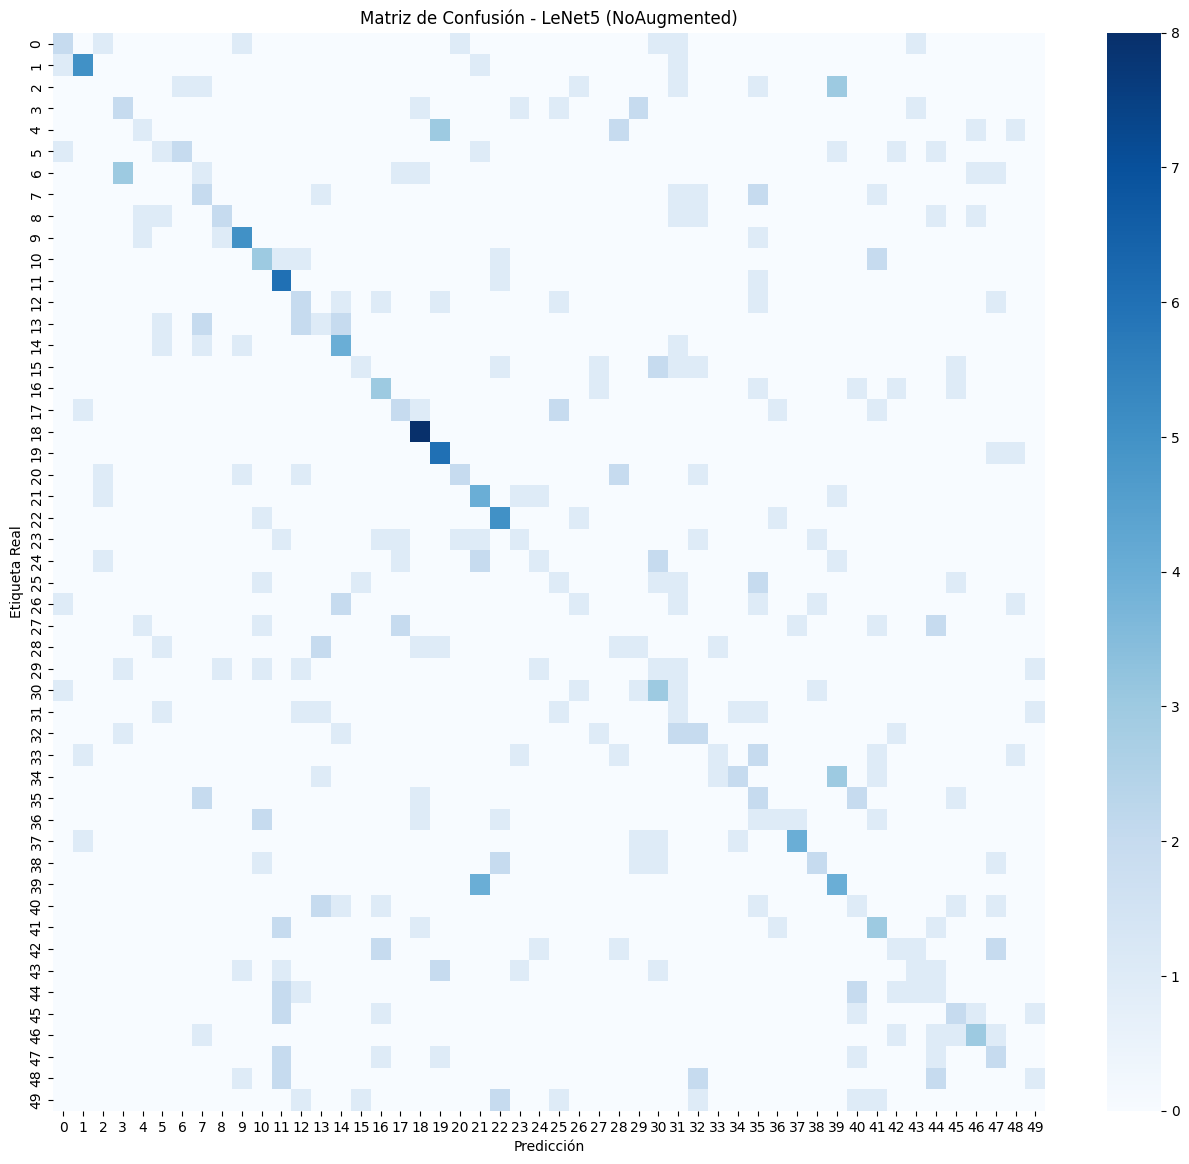

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,27
test_auc,80.17538
test_f1,25.00778
test_loss,3.09412
test_prec,25.99782


In [18]:
resultados_test = evaluar_experimento_LeNet5(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 2

In [19]:
# Configuración de Hiperparámetros
config = getConfig(1)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_LeNet5(
	config=config,
	train_dataset=train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=False,
	num_prueba=2
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 64
epochs: 100
alpha: 0.0001
weight_decay: 5e-05
dropout: 0.25
patience: 15

Época [1/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 3.7894 | Acc: 6.75% | Prec: 6.43% | Rec: 6.75% | F1: 4.85% | AUC: 65.55%
  Validación    -> Pérdida: 3.5069 | Acc: 12.00% | Prec: 8.09% | Rec: 12.00% | F1: 6.92% | AUC: 75.21%

Época [2/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 3.3380 | Acc: 17.42% | Prec: 19.71% | Rec: 17.42% | F1: 15.52% | AUC: 78.68%
  Validación    -> Pérdida: 3.3675 | Acc: 16.00% | Prec: 13.23% | Rec: 16.00% | F1: 12.40% | AUC: 78.22%

Época [3/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 3.1125 | Acc: 24.83% | Prec: 30.38% | Rec: 24.83% | F1: 23.28% | AUC: 84.12%
  Validación    -> Pérdida: 3.2007 | Acc: 19.00% | Prec: 14.23% | Rec: 19.00% | F1: 14.36% | AUC: 81.27%

Época [4/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 2.8556 | Acc: 32.25% | Prec: 38.54% | Rec: 32.25% | F1: 30.80% | AUC: 88.98%
  Vali

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▂▃▄▅▆▆▇▇█████████████████████
train_auc,▁▄▅▆▆▇█████████████████████████
train_f1,▁▂▂▃▄▅▆▆▇▇█████████████████████
train_loss,█▇▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▃▃▄▅▆▇▇▇█████████████████████
train_rec,▁▂▂▃▄▅▆▆▇▇█████████████████████
validation_acc,▁▂▃▄▅▇▇▇▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
validation_auc,▁▃▆▆█████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▅
+4,...


#### Resultados de la Prueba 2


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 3.0979
Precisión (Acc): 27.00%
Precision: 25.32%
Recall: 27.00%
F1-Score: 24.78%
AUC: 79.59%



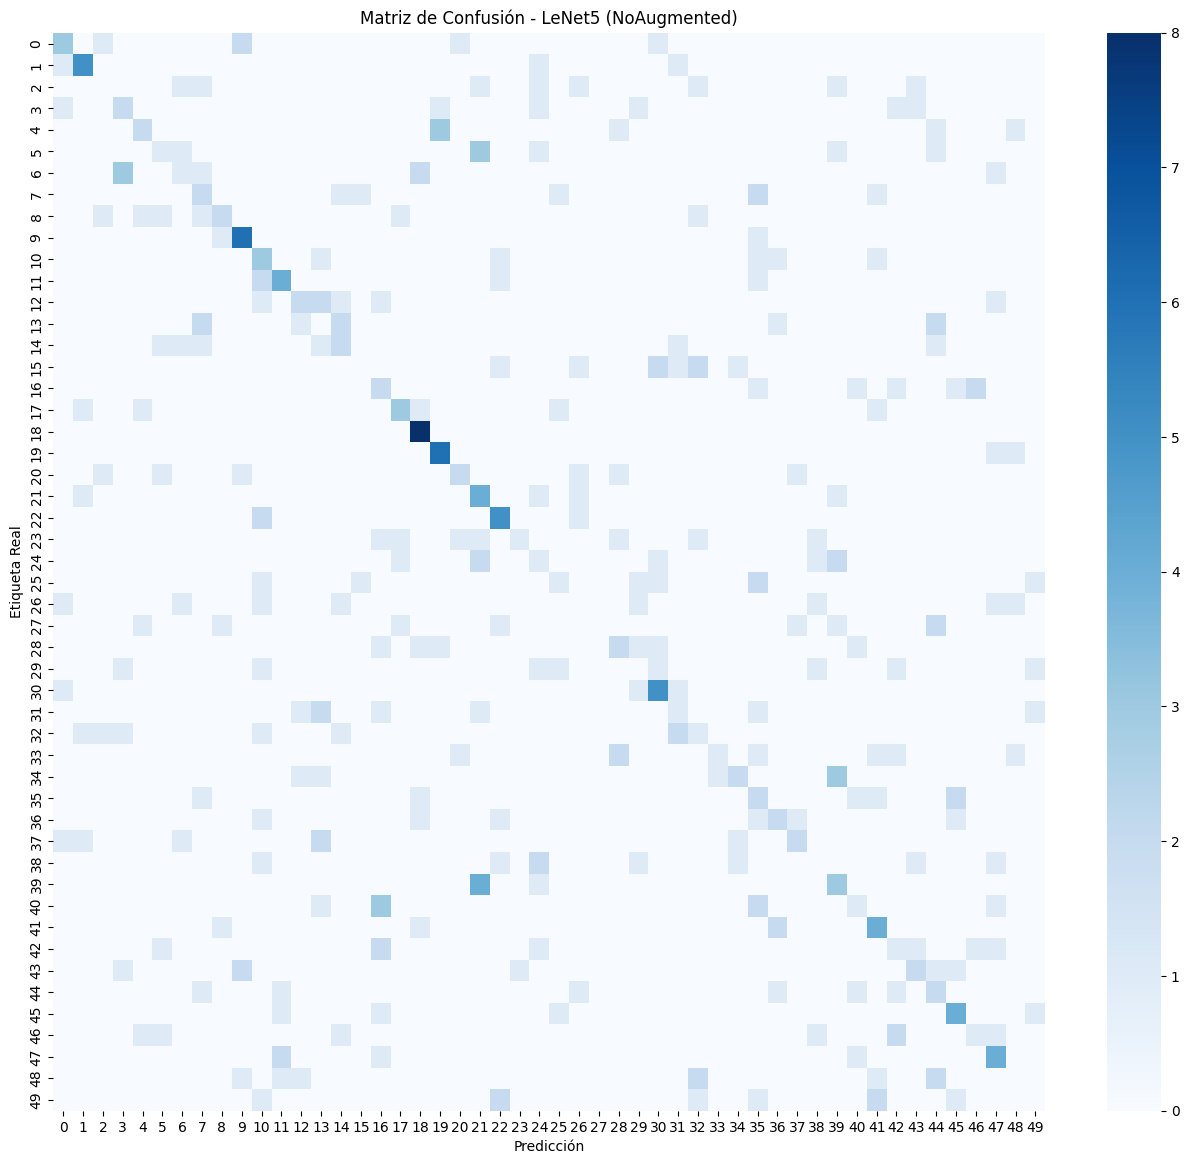

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,27
test_auc,79.59439
test_f1,24.78425
test_loss,3.0979
test_prec,25.3187


In [20]:
resultados_test = evaluar_experimento_LeNet5(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 3

In [21]:
# Configuración de Hiperparámetros
config = getConfig(2)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_LeNet5(
	config=config,
	train_dataset=train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=False,
	num_prueba=3
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 64
epochs: 120
alpha: 0.0005
weight_decay: 0.0001
dropout: 0.3
patience: 15

Época [1/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 3.8940 | Acc: 5.83% | Prec: 6.56% | Rec: 5.83% | F1: 4.18% | AUC: 62.43%
  Validación    -> Pérdida: 3.7558 | Acc: 6.75% | Prec: 3.39% | Rec: 6.75% | F1: 3.96% | AUC: 64.08%

Época [2/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 3.5919 | Acc: 8.75% | Prec: 8.69% | Rec: 8.75% | F1: 7.27% | AUC: 71.59%
  Validación    -> Pérdida: 3.5794 | Acc: 6.50% | Prec: 5.15% | Rec: 6.50% | F1: 4.33% | AUC: 73.02%

Época [3/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 3.4661 | Acc: 10.58% | Prec: 9.79% | Rec: 10.58% | F1: 8.74% | AUC: 75.64%
  Validación    -> Pérdida: 3.4561 | Acc: 10.75% | Prec: 7.41% | Rec: 10.75% | F1: 7.45% | AUC: 75.73%

Época [4/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 3.3820 | Acc: 12.25% | Prec: 12.34% | Rec: 12.25% | F1: 10.13% | AUC: 77.47%
  Validación    -> P

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█▇███
train_auc,▁▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇████████████
train_f1,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▇▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁
train_prec,▁▁▁▂▂▃▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇█▇███
train_rec,▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▆▆▇▇▇▇███
validation_acc,▂▂▁▃▃▄▃▄▅▅▄▅▅▆▄▅▅▆▆▆▆█▇▆▆▇▇▇▇▇▇▇█▇▇▇███▇
validation_auc,▁▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇███████████████
+4,...


#### Resultados de la Prueba 3


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 2.9162
Precisión (Acc): 24.25%
Precision: 24.00%
Recall: 24.25%
F1-Score: 23.18%
AUC: 85.41%



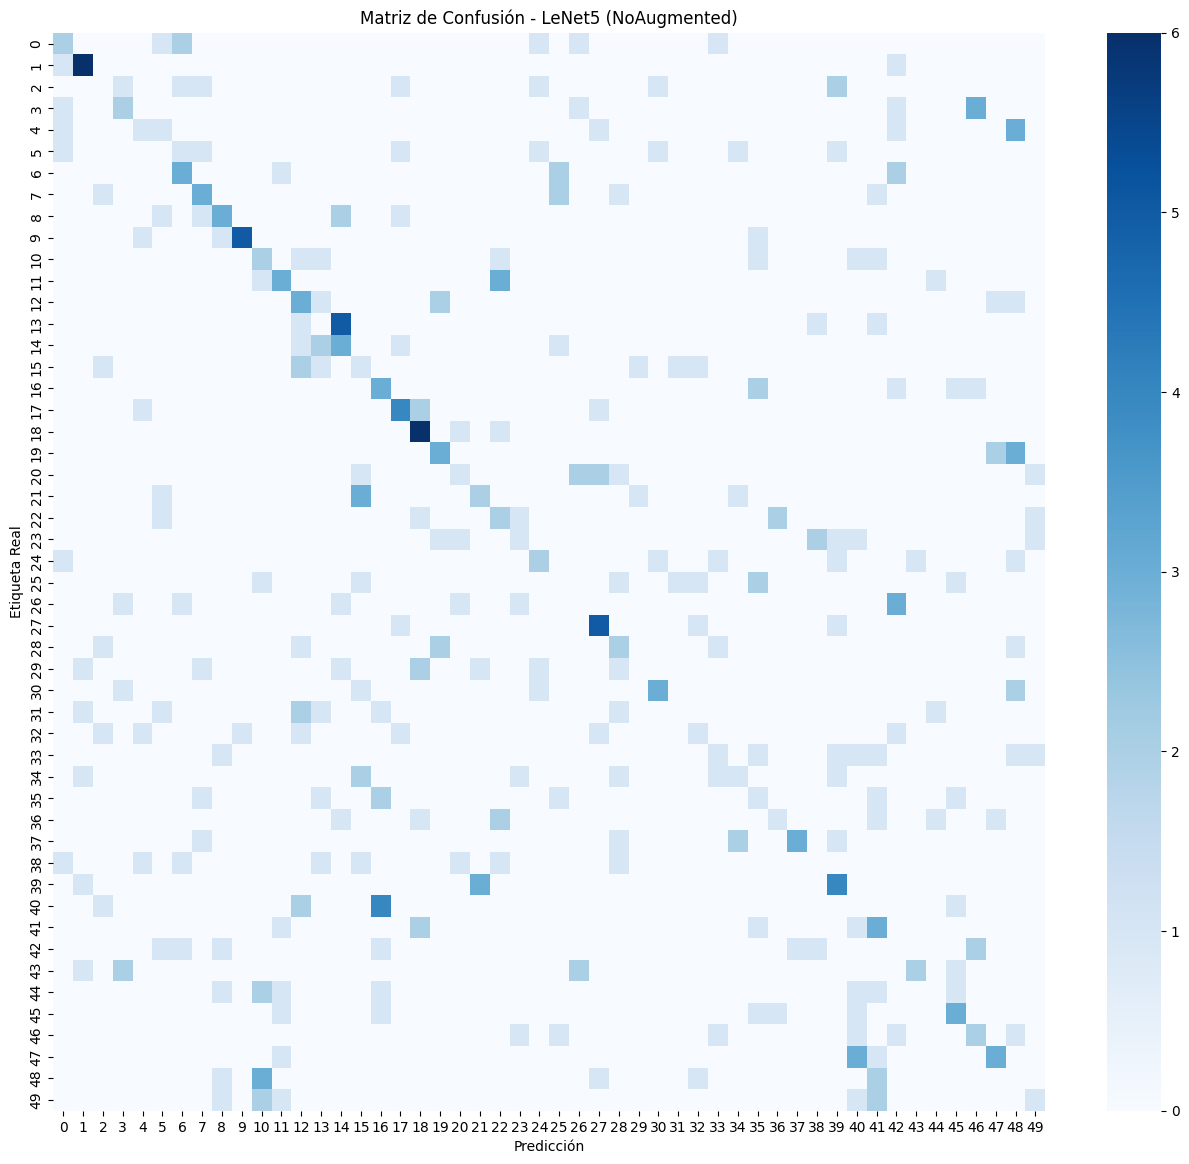

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,24.25
test_auc,85.40753
test_f1,23.17841
test_loss,2.91622
test_prec,24.00448


In [22]:
resultados_test = evaluar_experimento_LeNet5(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 4

In [23]:
# Configuración de Hiperparámetros
config = getConfig(3)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_LeNet5(
	config=config,
	train_dataset=train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=False,
	num_prueba=4
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 64
epochs: 120
alpha: 0.0002
weight_decay: 0.0002
dropout: 0.35
patience: 15

Época [1/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 3.9014 | Acc: 5.25% | Prec: 2.62% | Rec: 5.25% | F1: 2.90% | AUC: 62.06%
  Validación    -> Pérdida: 3.7170 | Acc: 7.00% | Prec: 2.58% | Rec: 7.00% | F1: 2.90% | AUC: 70.08%

Época [2/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 3.5577 | Acc: 10.33% | Prec: 12.57% | Rec: 10.33% | F1: 8.42% | AUC: 72.96%
  Validación    -> Pérdida: 3.5456 | Acc: 10.25% | Prec: 7.39% | Rec: 10.25% | F1: 6.31% | AUC: 73.46%

Época [3/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 3.3939 | Acc: 15.08% | Prec: 21.22% | Rec: 15.08% | F1: 13.97% | AUC: 76.92%
  Validación    -> Pérdida: 3.4987 | Acc: 12.75% | Prec: 10.24% | Rec: 12.75% | F1: 8.81% | AUC: 75.19%

Época [4/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 3.2448 | Acc: 17.50% | Prec: 21.79% | Rec: 17.50% | F1: 15.95% | AUC: 80.72%
  Validació

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇▇███████████████████
train_auc,▁▃▄▄▅▆▆▇▇▇▇▇██████████████████████████
train_f1,▁▁▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇▇▇███████████████████
train_loss,█▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇▇▇████████████████████
train_rec,▁▁▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇▇███████████████████
validation_acc,▁▂▃▄▃▅▅▆▆▇▇▇▆▆▇▇█▇▇▇██████████████▇▇█▇
validation_auc,▁▃▃▅▅▆▆▇▇▇███▇█▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
+4,...


#### Resultados de la Prueba 4


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 3.0066
Precisión (Acc): 25.50%
Precision: 25.66%
Recall: 25.50%
F1-Score: 23.78%
AUC: 82.27%



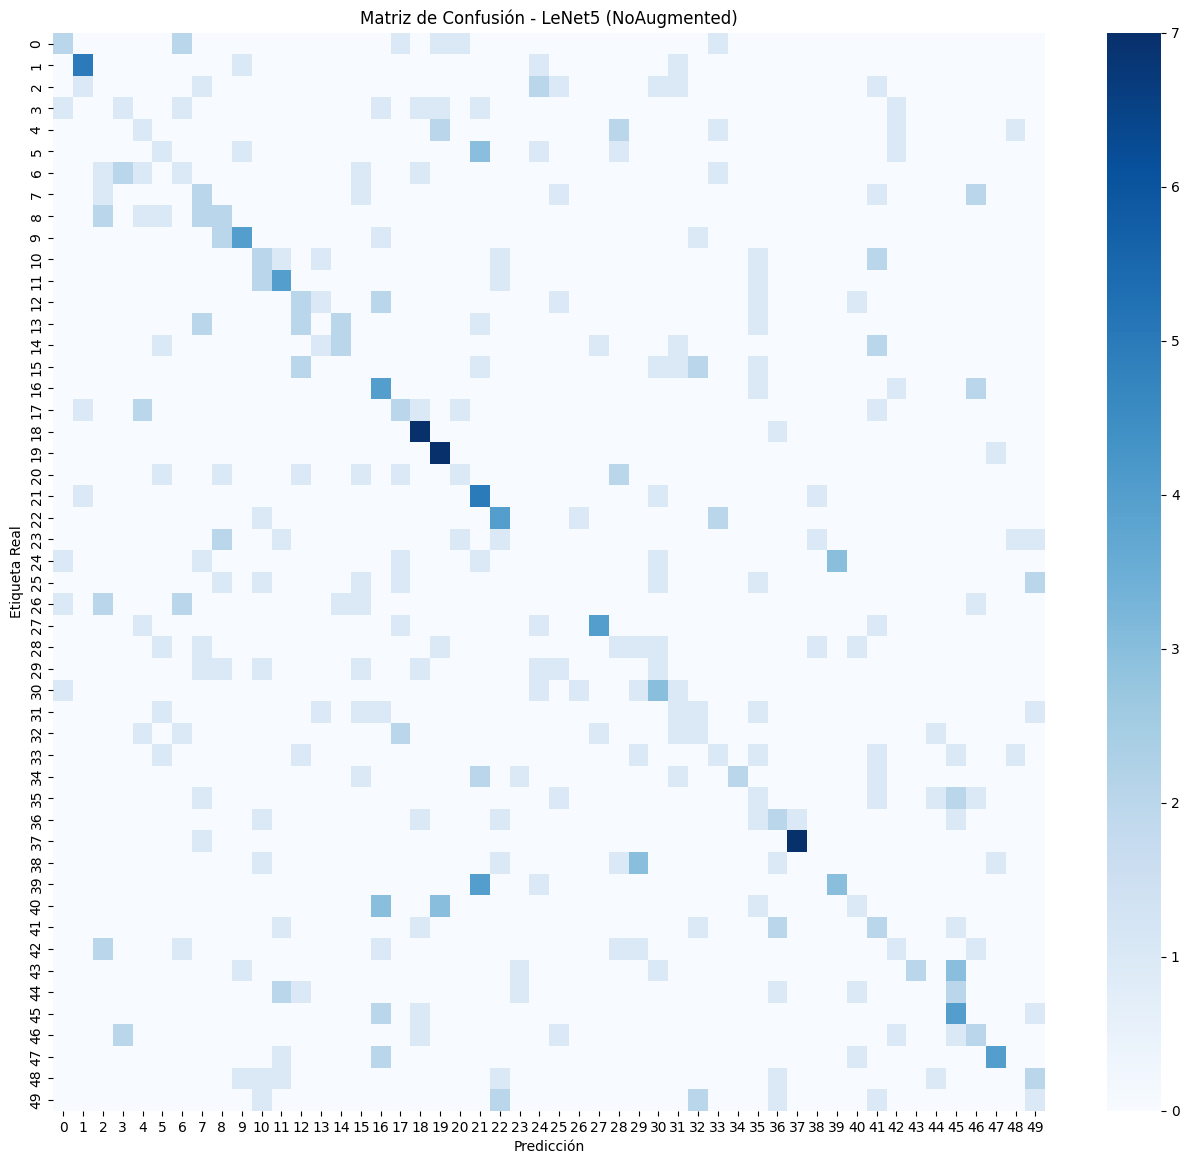

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,25.5
test_auc,82.26786
test_f1,23.78413
test_loss,3.0066
test_prec,25.65854


In [24]:
resultados_test = evaluar_experimento_LeNet5(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 5

In [25]:
# Configuración de Hiperparámetros
config = getConfig(4)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_LeNet5(
	config=config,
	train_dataset=train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=False,
	num_prueba=5
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 32
epochs: 60
alpha: 7.5e-05
weight_decay: 5e-05
dropout: 0.3
patience: 15

Época [1/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 3.8035 | Acc: 5.50% | Prec: 4.24% | Rec: 5.50% | F1: 3.95% | AUC: 65.20%
  Validación    -> Pérdida: 3.5741 | Acc: 7.50% | Prec: 7.77% | Rec: 7.50% | F1: 4.65% | AUC: 73.56%

Época [2/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 3.3836 | Acc: 15.25% | Prec: 15.74% | Rec: 15.25% | F1: 13.49% | AUC: 77.90%
  Validación    -> Pérdida: 3.3940 | Acc: 16.50% | Prec: 13.01% | Rec: 16.50% | F1: 11.71% | AUC: 77.40%

Época [3/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 3.1291 | Acc: 24.58% | Prec: 26.96% | Rec: 24.58% | F1: 22.66% | AUC: 82.96%
  Validación    -> Pérdida: 3.2405 | Acc: 18.50% | Prec: 17.08% | Rec: 18.50% | F1: 14.78% | AUC: 80.27%

Época [4/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 2.8067 | Acc: 34.75% | Prec: 38.70% | Rec: 34.75% | F1: 32.58% | AUC: 88.82%
  Validación 

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▂▃▄▅▆▇▇▇█████████████████
train_auc,▁▄▅▆▇▇█████████████████████
train_f1,▁▂▂▃▄▅▆▇▇▇█████████████████
train_loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▃▄▅▆▆▇▇▇█████████████████
train_rec,▁▂▂▃▄▅▆▇▇▇█████████████████
validation_acc,▁▃▄▅▆▆▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
validation_auc,▁▄▆▆█▇██▇███▇▇▇▇▇▇▇▆▆▆▆▆▇▆▆
+4,...


#### Resultados de la Prueba 5


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 3.0818
Precisión (Acc): 27.50%
Precision: 27.21%
Recall: 27.50%
F1-Score: 25.92%
AUC: 80.46%



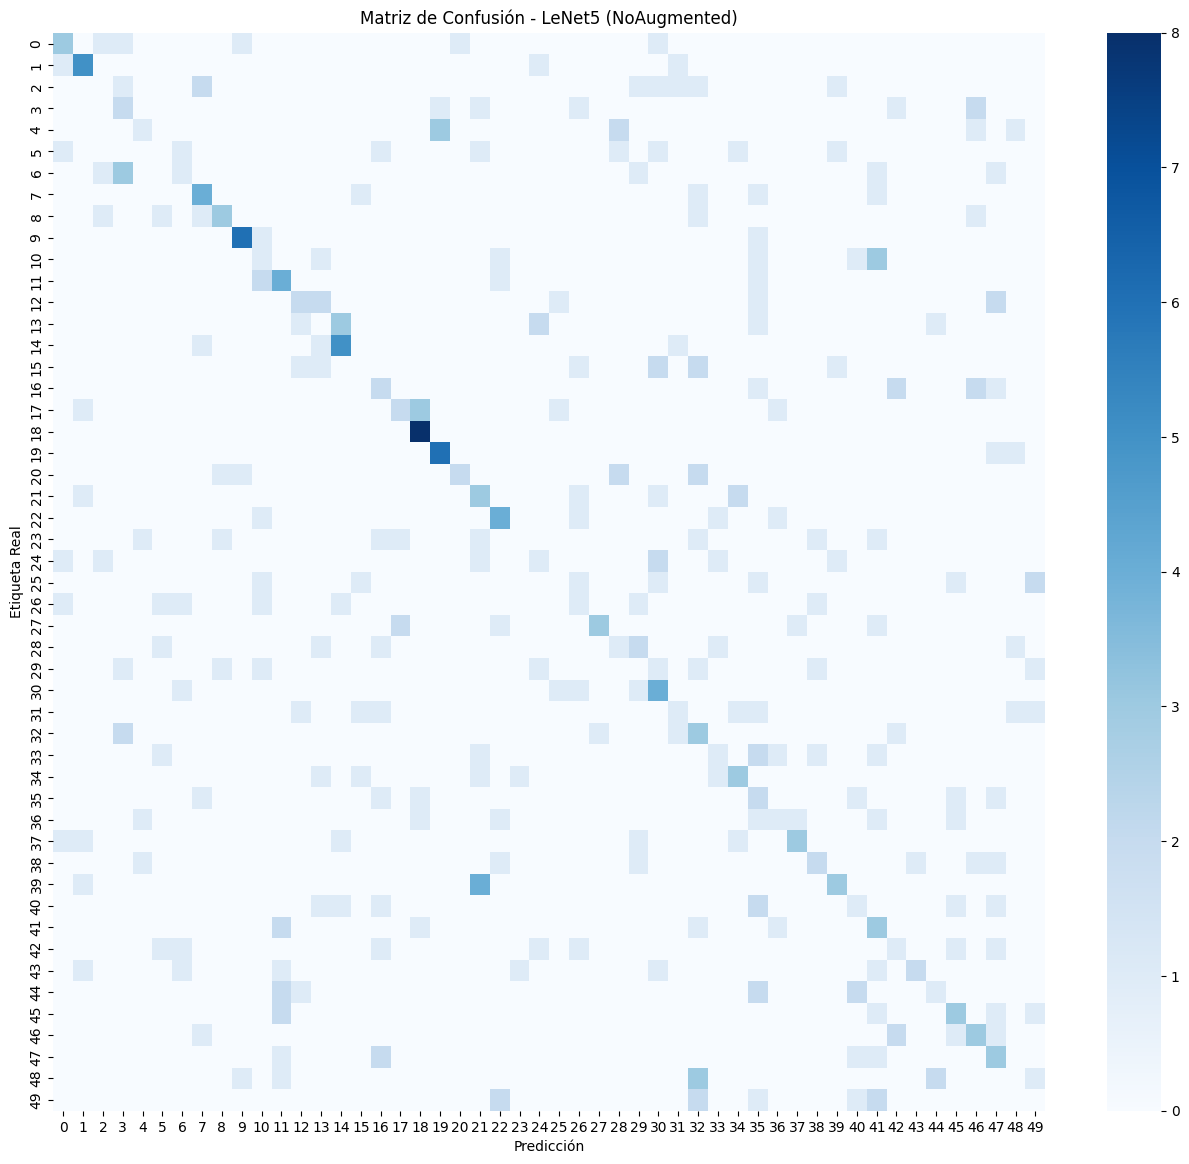

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,27.5
test_auc,80.4611
test_f1,25.91793
test_loss,3.08181
test_prec,27.20706


In [26]:
resultados_test = evaluar_experimento_LeNet5(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

### Pruebas con el Dataset Augmentado

In [27]:
# Configuración del Dataset
augmented_train_dataset = AudioSpectrogramDataset(augmented_training_set, augmented=True)
val_dataset = AudioSpectrogramDataset(validation_set, augmented=False)
test_dataset = AudioSpectrogramDataset(testing_set, augmented=False)

#### Ejecución de la Prueba 1

In [28]:
# Configuración de Hiperparámetros
config = getConfig(0)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_LeNet5(
	config=config,
	train_dataset=augmented_train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=True,
	num_prueba=1
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 32
epochs: 80
alpha: 5e-05
weight_decay: 1e-05
dropout: 0.3
patience: 15

Época [1/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 3.7463 | Acc: 7.75% | Prec: 7.31% | Rec: 7.75% | F1: 6.40% | AUC: 66.65%
  Validación    -> Pérdida: 3.4888 | Acc: 10.50% | Prec: 10.47% | Rec: 10.50% | F1: 8.29% | AUC: 75.35%

Época [2/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 3.1785 | Acc: 20.92% | Prec: 21.94% | Rec: 20.92% | F1: 18.70% | AUC: 82.76%
  Validación    -> Pérdida: 3.2941 | Acc: 17.50% | Prec: 16.90% | Rec: 17.50% | F1: 13.70% | AUC: 79.42%

Época [3/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 2.7217 | Acc: 38.33% | Prec: 40.72% | Rec: 38.33% | F1: 36.91% | AUC: 90.79%
  Validación    -> Pérdida: 3.1258 | Acc: 24.75% | Prec: 22.33% | Rec: 24.75% | F1: 21.29% | AUC: 81.64%

Época [4/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 2.2488 | Acc: 58.25% | Prec: 60.86% | Rec: 58.25% | F1: 57.61% | AUC: 95.91%
  Validación

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▅▆▇▇██████████████████
train_auc,▁▄▆▇█████████████████████
train_f1,▁▂▃▅▆▇███████████████████
train_loss,█▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▄▅▆▇███████████████████
train_rec,▁▂▃▅▆▇▇██████████████████
validation_acc,▁▃▆▇▇▇██▇█▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇
validation_auc,▁▄▆█████████▇▇▇▇▇▇▇▆▆▇▆▆▆
+4,...


#### Resultados de la Prueba 1


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 2.9849
Precisión (Acc): 26.25%
Precision: 26.83%
Recall: 26.25%
F1-Score: 24.22%
AUC: 82.51%



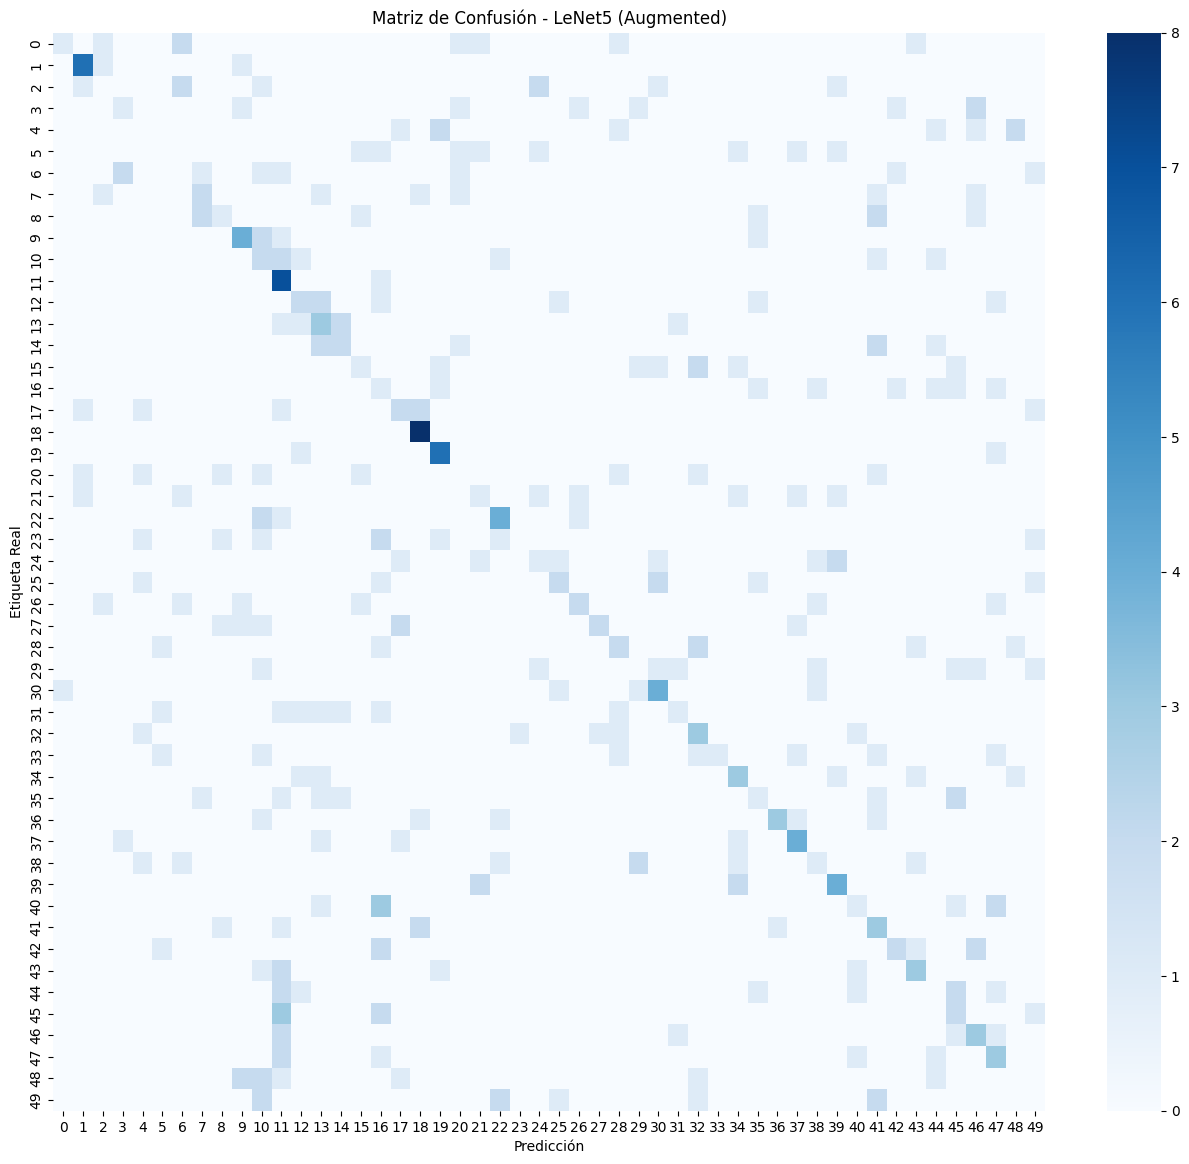

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,26.25
test_auc,82.51084
test_f1,24.22203
test_loss,2.98486
test_prec,26.82781


In [29]:
resultados_test = evaluar_experimento_LeNet5(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 2

In [30]:
# Configuración de Hiperparámetros
config = getConfig(1)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_LeNet5(
	config=config,
	train_dataset=augmented_train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=True,
	num_prueba=2
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 64
epochs: 100
alpha: 0.0001
weight_decay: 5e-05
dropout: 0.25
patience: 15

Época [1/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 3.7521 | Acc: 7.22% | Prec: 9.20% | Rec: 7.22% | F1: 6.04% | AUC: 66.25%
  Validación    -> Pérdida: 3.5553 | Acc: 10.75% | Prec: 7.21% | Rec: 10.75% | F1: 6.91% | AUC: 72.76%

Época [2/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 3.2381 | Acc: 18.14% | Prec: 19.14% | Rec: 18.14% | F1: 16.78% | AUC: 81.02%
  Validación    -> Pérdida: 3.3788 | Acc: 14.50% | Prec: 17.78% | Rec: 14.50% | F1: 12.35% | AUC: 78.04%

Época [3/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 2.7953 | Acc: 34.03% | Prec: 37.17% | Rec: 34.03% | F1: 32.68% | AUC: 89.72%
  Validación    -> Pérdida: 3.0939 | Acc: 22.00% | Prec: 22.75% | Rec: 22.00% | F1: 18.90% | AUC: 82.56%

Época [4/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 2.3170 | Acc: 53.56% | Prec: 56.11% | Rec: 53.56% | F1: 52.62% | AUC: 95.22%
  Vali

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▄▆▇▇██████████████████
train_auc,▁▄▆▇█████████████████████
train_f1,▁▂▃▄▆▇▇██████████████████
train_loss,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▃▅▆▇▇██████████████████
train_rec,▁▂▃▄▆▇▇██████████████████
validation_acc,▁▂▅▆████▇██▇▇█▇▇▇▇▇█▇▇▇▇▇
validation_auc,▁▄▆▇█▇██████▇▇▇▇▇▇▇▇▇▆▆▆▆
+4,...


#### Resultados de la Prueba 2


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 2.9658
Precisión (Acc): 27.25%
Precision: 24.76%
Recall: 27.25%
F1-Score: 24.72%
AUC: 83.02%



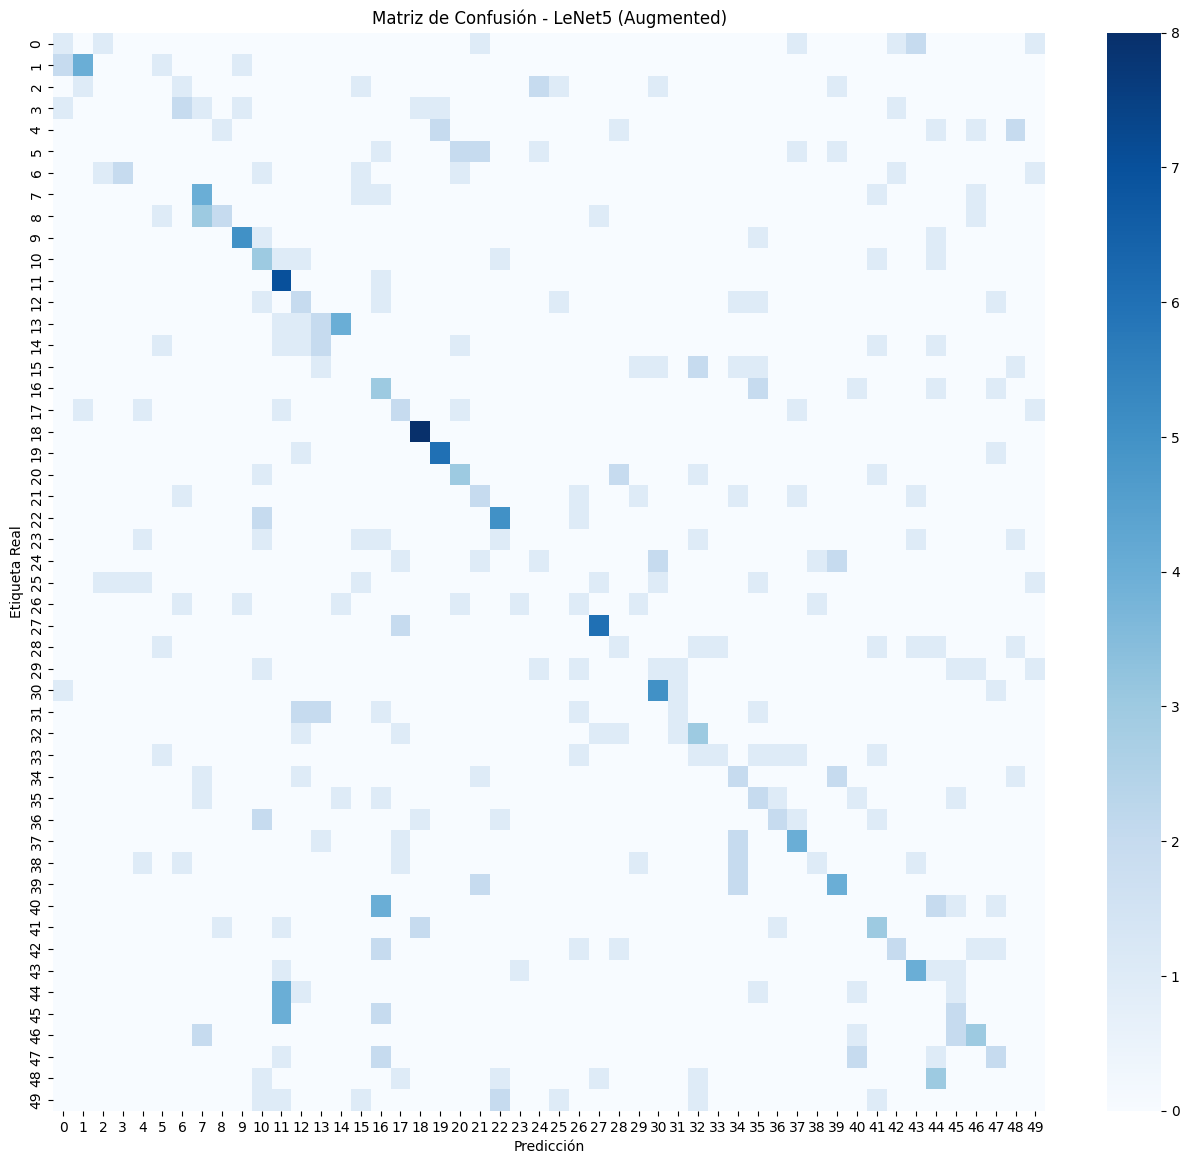

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,27.25
test_auc,83.0236
test_f1,24.71956
test_loss,2.96576
test_prec,24.76108


In [31]:
resultados_test = evaluar_experimento_LeNet5(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 3

In [32]:
# Configuración de Hiperparámetros
config = getConfig(2)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_LeNet5(
	config=config,
	train_dataset=augmented_train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=True,
	num_prueba=3
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 64
epochs: 120
alpha: 0.0005
weight_decay: 0.0001
dropout: 0.3
patience: 15

Época [1/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 3.8441 | Acc: 5.17% | Prec: 4.26% | Rec: 5.17% | F1: 4.12% | AUC: 63.72%
  Validación    -> Pérdida: 3.6829 | Acc: 7.25% | Prec: 6.37% | Rec: 7.25% | F1: 4.50% | AUC: 69.92%

Época [2/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 3.6187 | Acc: 6.97% | Prec: 7.12% | Rec: 6.97% | F1: 6.07% | AUC: 71.16%
  Validación    -> Pérdida: 3.5641 | Acc: 9.25% | Prec: 4.33% | Rec: 9.25% | F1: 5.14% | AUC: 74.60%

Época [3/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 3.5378 | Acc: 8.00% | Prec: 7.30% | Rec: 8.00% | F1: 6.60% | AUC: 73.52%
  Validación    -> Pérdida: 3.5194 | Acc: 8.75% | Prec: 7.50% | Rec: 8.75% | F1: 5.33% | AUC: 75.47%

Época [4/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 3.4297 | Acc: 10.25% | Prec: 10.07% | Rec: 10.25% | F1: 8.56% | AUC: 76.32%
  Validación    -> Pérdid

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
train_auc,▁▄▄▅▅▅▆▆▆▆▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇████████████
train_f1,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss,█▇▇▇▆▆▆▆▆▅▅▄▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
train_prec,▁▂▂▃▃▃▃▄▄▄▄▄▄▄▅▄▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇█▇███
train_rec,▁▁▂▂▂▃▄▄▄▄▄▄▄▅▅▅▅▅▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇██
validation_acc,▁▂▃▂▃▂▃▃▅▅▄▂▅▄▄▅▆▅▆▄▆▇▆▇▆▅▆███▇▇▇▇▇▆▇███
validation_auc,▁▃▃▄▄▅▆▆▆▇▆▇▇▇▅▇▆▇▇▇▇█▇▇▇▇██▇▇█████▇▇███
+4,...


#### Resultados de la Prueba 3


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 2.9570
Precisión (Acc): 26.25%
Precision: 28.86%
Recall: 26.25%
F1-Score: 25.30%
AUC: 85.64%



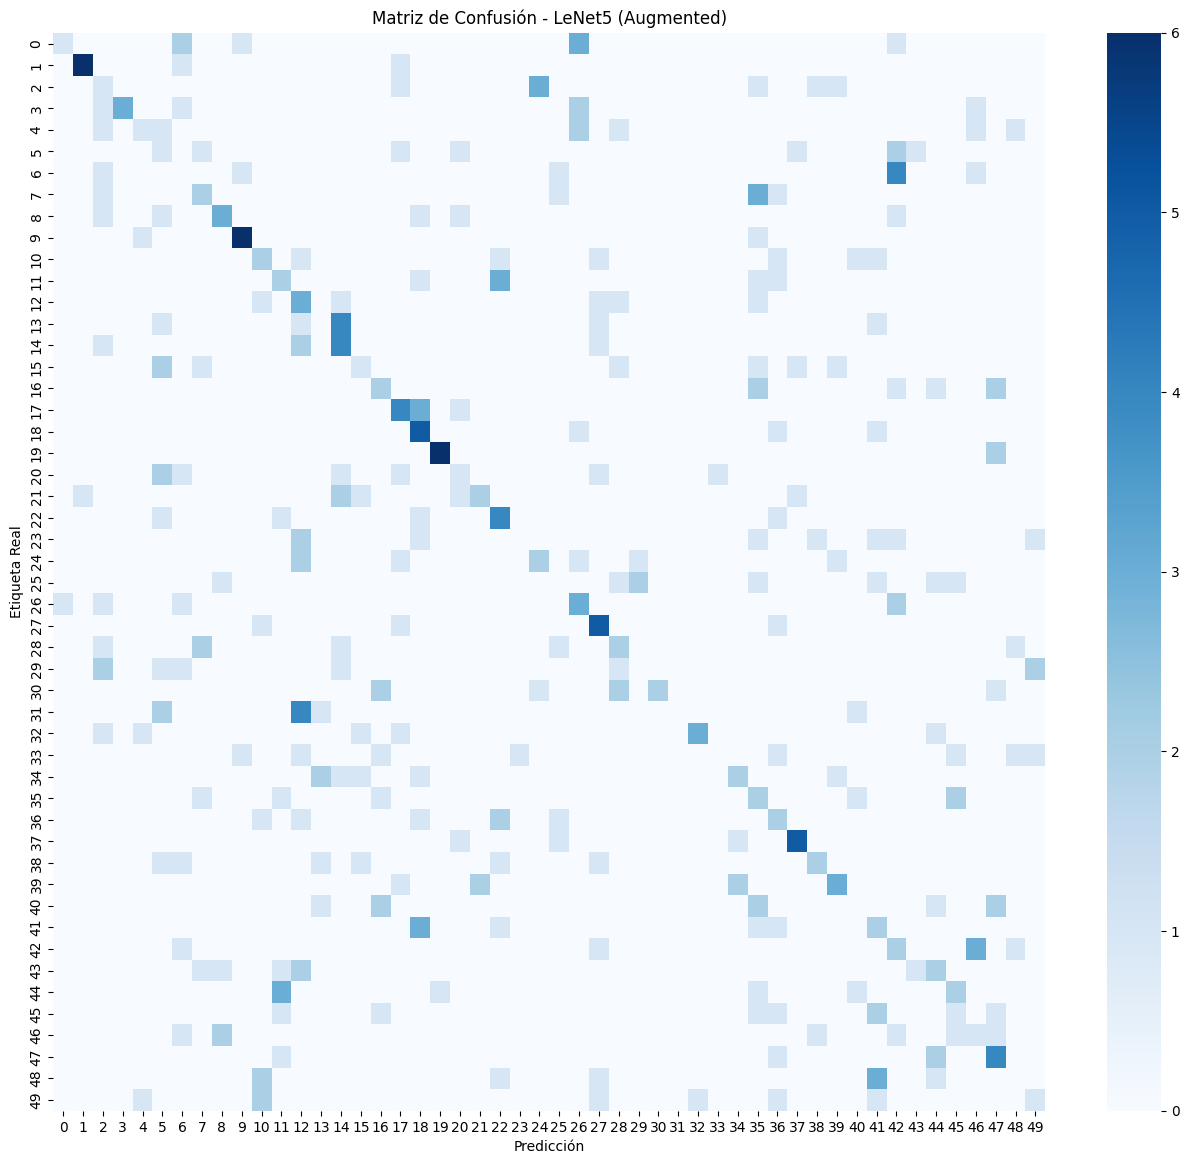

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,26.25
test_auc,85.63967
test_f1,25.29835
test_loss,2.95696
test_prec,28.85741


In [33]:
resultados_test = evaluar_experimento_LeNet5(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 4

In [34]:
# Configuración de Hiperparámetros
config = getConfig(3)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_LeNet5(
	config=config,
	train_dataset=augmented_train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=True,
	num_prueba=4
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 64
epochs: 120
alpha: 0.0002
weight_decay: 0.0002
dropout: 0.35
patience: 15

Época [1/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 3.8575 | Acc: 5.19% | Prec: 4.72% | Rec: 5.19% | F1: 4.26% | AUC: 63.50%
  Validación    -> Pérdida: 3.6679 | Acc: 6.50% | Prec: 6.54% | Rec: 6.50% | F1: 4.49% | AUC: 69.40%

Época [2/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 3.5876 | Acc: 7.94% | Prec: 8.18% | Rec: 7.94% | F1: 7.30% | AUC: 71.85%
  Validación    -> Pérdida: 3.7153 | Acc: 7.00% | Prec: 5.58% | Rec: 7.00% | F1: 5.18% | AUC: 71.31%

Sin mejora por 1 épocas consecutivas.
Época [3/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 3.4224 | Acc: 11.50% | Prec: 10.82% | Rec: 11.50% | F1: 10.32% | AUC: 76.55%
  Validación    -> Pérdida: 3.4454 | Acc: 13.50% | Prec: 11.73% | Rec: 13.50% | F1: 9.84% | AUC: 77.25%

Época [4/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 3.2401 | Acc: 16.08% | Prec: 17.27% | Rec: 16.08% | F1:

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▁▂▂▃▄▄▅▆▆▇▇███████████████
train_auc,▁▃▄▄▅▆▆▇▇███████████████████
train_f1,▁▁▁▂▂▃▄▄▅▆▆▇▇███████████████
train_loss,██▇▇▆▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▁▁▂▃▃▄▅▅▆▇▇▇███████████████
train_rec,▁▁▁▂▂▃▄▄▅▆▆▇▇███████████████
validation_acc,▁▁▃▃▃▅▆▆▆▆█▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇
validation_auc,▁▂▄▅▆▇▇▇▇▇▇████████▇▇▇▇▇▇▇▇▇
+4,...


#### Resultados de la Prueba 4


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 2.8940
Precisión (Acc): 23.25%
Precision: 23.27%
Recall: 23.25%
F1-Score: 21.82%
AUC: 85.26%



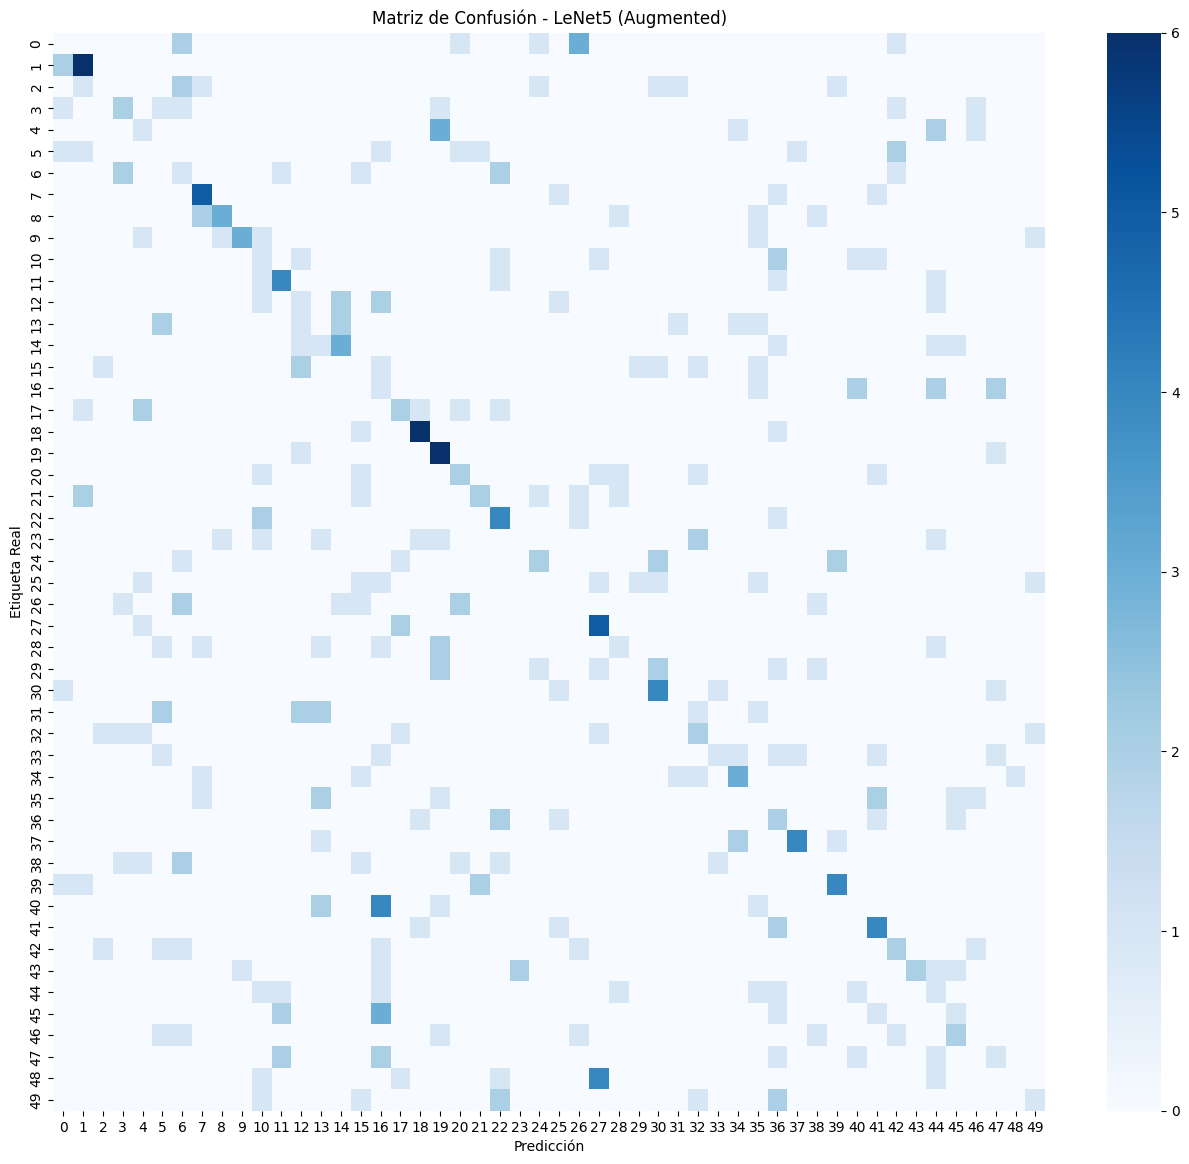

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,23.25
test_auc,85.25765
test_f1,21.81915
test_loss,2.89403
test_prec,23.27429


In [35]:
resultados_test = evaluar_experimento_LeNet5(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 5

In [36]:
# Configuración de Hiperparámetros
config = getConfig(4)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_LeNet5(
	config=config,
	train_dataset=augmented_train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=True,
	num_prueba=5
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 32
epochs: 60
alpha: 7.5e-05
weight_decay: 5e-05
dropout: 0.3
patience: 15

Época [1/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 3.7581 | Acc: 7.00% | Prec: 6.57% | Rec: 7.00% | F1: 5.87% | AUC: 66.48%
  Validación    -> Pérdida: 3.5016 | Acc: 9.75% | Prec: 9.91% | Rec: 9.75% | F1: 7.78% | AUC: 74.48%

Época [2/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 3.2569 | Acc: 18.39% | Prec: 18.42% | Rec: 18.39% | F1: 16.87% | AUC: 80.76%
  Validación    -> Pérdida: 3.3056 | Acc: 15.75% | Prec: 17.42% | Rec: 15.75% | F1: 13.28% | AUC: 79.16%

Época [3/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 2.7849 | Acc: 35.06% | Prec: 37.91% | Rec: 35.06% | F1: 33.58% | AUC: 89.71%
  Validación    -> Pérdida: 3.0791 | Acc: 24.00% | Prec: 23.60% | Rec: 24.00% | F1: 21.35% | AUC: 83.21%

Época [4/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 2.2830 | Acc: 55.67% | Prec: 58.77% | Rec: 55.67% | F1: 54.89% | AUC: 95.30%
  Validación 

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▅▆▇████████████████
train_auc,▁▄▆▇██████████████████
train_f1,▁▂▃▅▆▇████████████████
train_loss,█▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▃▅▆▇████████████████
train_rec,▁▂▃▅▆▇████████████████
validation_acc,▁▃▆█▇▇████▇▇▇▇▇▇▇▇▇▆▇▇
validation_auc,▁▄▇██▇█▇█▇▇▇▇▇▇▇▇▆▆▆▆▆
+4,...


#### Resultados de la Prueba 5


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 2.9280
Precisión (Acc): 26.25%
Precision: 28.35%
Recall: 26.25%
F1-Score: 24.75%
AUC: 84.48%



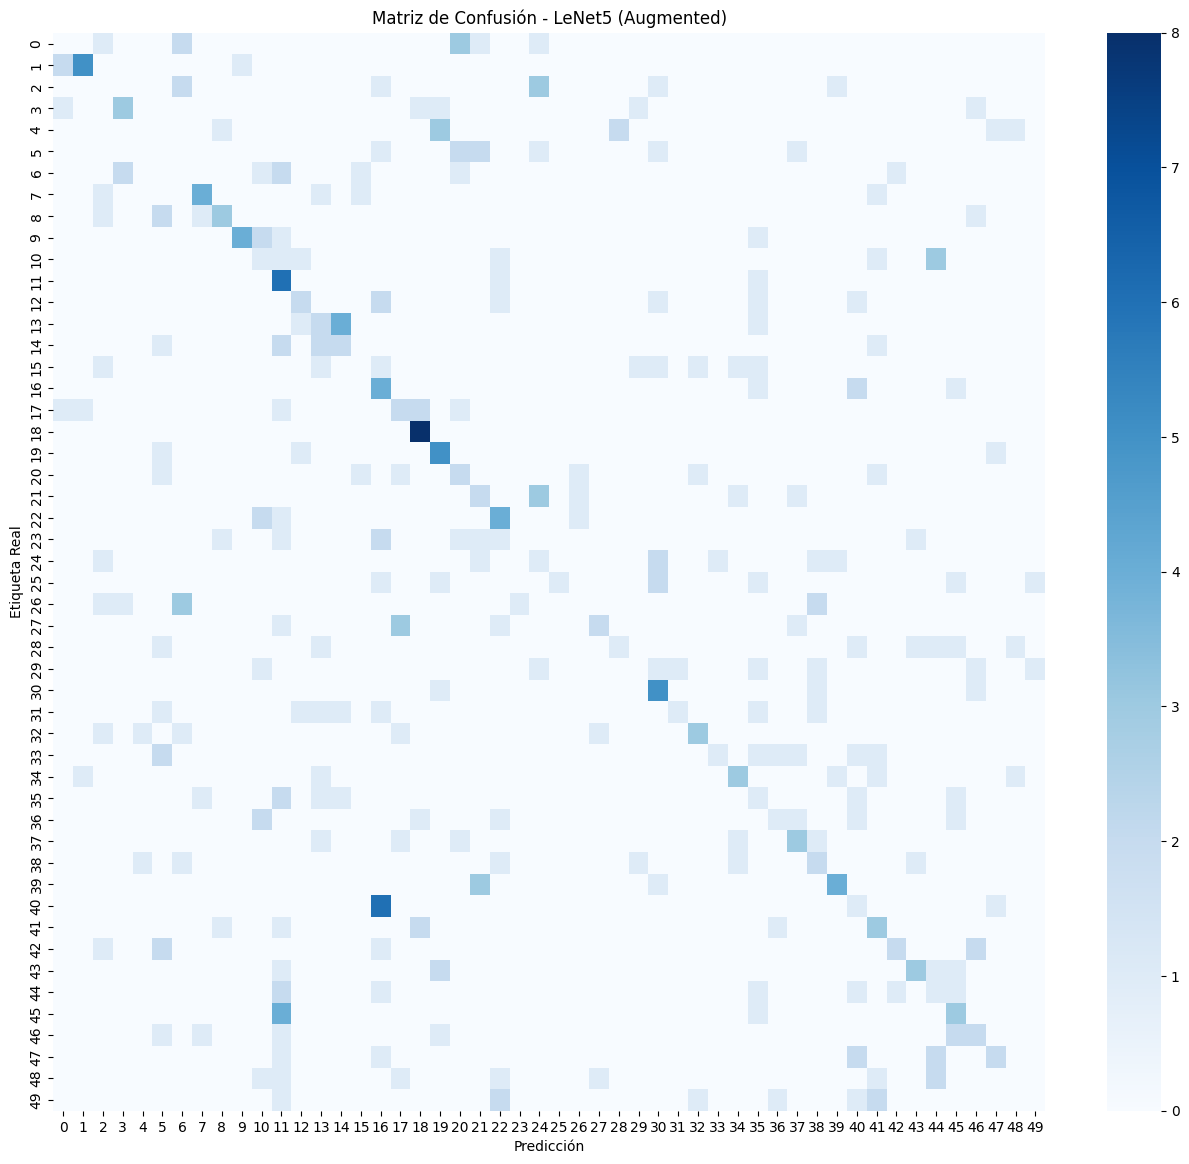

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,26.25
test_auc,84.47704
test_f1,24.74782
test_loss,2.92805
test_prec,28.35031


In [37]:
resultados_test = evaluar_experimento_LeNet5(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

## Modelo B (ResNet)

### Creación del modelo

In [38]:
class BasicBlock(nn.Module):
	expansion = 1

	def __init__(self, in_channels, out_channels, stride=1, downsample=None):
		super(BasicBlock, self).__init__()
		self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
							stride=stride, padding=1, bias=False)
		self.bn1 = nn.BatchNorm2d(out_channels)
		
		self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
							stride=1, padding=1, bias=False)
		self.bn2 = nn.BatchNorm2d(out_channels)
		
		self.downsample = downsample 
		self.relu = nn.ReLU(inplace=True)

	def forward(self, x):
		identity = x
		if self.downsample is not None:
			identity = self.downsample(x)

		out = self.relu(self.bn1(self.conv1(x)))
		out = self.bn2(self.conv2(out))
		out += identity
		return self.relu(out)


class ResNet18(nn.Module):
	def __init__(self, num_classes=50, dropout=0.3):
		super(ResNet18, self).__init__()

		self.in_channels = 64
		self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
		self.bn1 = nn.BatchNorm2d(64)
		self.relu = nn.ReLU(inplace=True)
		self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

		# Bloques residuales
		self.layer1 = self._make_layer(64, 2)
		self.layer2 = self._make_layer(128, 2, stride=2)
		self.layer3 = self._make_layer(256, 2, stride=2)
		self.layer4 = self._make_layer(512, 2, stride=2)

		self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
		self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)
		self.dropout = nn.Dropout(p=dropout)

		self._initialize_weights()

	def _make_layer(self, out_channels, blocks, stride=1):
		downsample = None
		if stride != 1 or self.in_channels != out_channels * BasicBlock.expansion:
			downsample = nn.Sequential(
				nn.Conv2d(self.in_channels, out_channels * BasicBlock.expansion,
						kernel_size=1, stride=stride, bias=False),
				nn.BatchNorm2d(out_channels * BasicBlock.expansion)
			)

		layers = [BasicBlock(self.in_channels, out_channels, stride, downsample)]
		self.in_channels = out_channels * BasicBlock.expansion
		for _ in range(1, blocks):
			layers.append(BasicBlock(self.in_channels, out_channels))

		return nn.Sequential(*layers)

	def _initialize_weights(self):
		for m in self.modules():
			if isinstance(m, (nn.Conv2d, nn.Linear)):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
			elif isinstance(m, nn.BatchNorm2d):
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 0)

	def forward(self, x):
		x = self.relu(self.bn1(self.conv1(x)))
		x = self.maxpool(x)
		x = self.layer1(x)
		x = self.layer2(x)
		x = self.layer3(x)
		x = self.layer4(x)
		x = self.avgpool(x)
		x = torch.flatten(x, 1)
		x = self.dropout(x)
		return self.fc(x)

#### Función para Configurar y Entrenar

In [39]:
def ejecutar_experimento_ResNet18(config, train_dataset, val_dataset, test_dataset, augmentado, num_prueba):
	set_seed()

	train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
	val_loader   = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
	test_loader  = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

	if augmentado:
		dataset_type = "Augmented"
	else:
		dataset_type = "NoAugmented"

	model = ResNet18(
		num_classes=config["num_classes"],
		dropout=config["dropout"],
	).to(device)

	criterion = nn.CrossEntropyLoss()
	optimizer = optim.AdamW(model.parameters(), lr=config["alpha"], weight_decay=config["weight_decay"])

	model, history = entrenar(
		model=model,
		train_loader=train_loader,
		val_loader=val_loader,
		criterion=criterion,
		optimizer=optimizer,
		config=config,
		device=device,
		model_name="ResNet18",
		dataset_type=dataset_type,
		run_name=f"{num_prueba}_{dataset_type}_ResNet18",
		use_scheduler=True
	)

	return model, history, test_loader, criterion, dataset_type, num_prueba


def evaluar_experimento_ResNet18(model, test_loader, criterion, dataset_type, num_prueba):
	resultados_test = testear(
		model=model,
		test_loader=test_loader,
		criterion=criterion,
		device=device,
		model_name="ResNet18",
		dataset_type=dataset_type,
		run_name=f"{num_prueba}_{dataset_type}_ResNet18"
	)

	return resultados_test


### Pruebas con el Dataset Normal

In [40]:
# Configuración del Dataset
train_dataset = AudioSpectrogramDataset(training_set, augmented=False)
val_dataset = AudioSpectrogramDataset(validation_set, augmented=False)
test_dataset = AudioSpectrogramDataset(testing_set, augmented=False)

#### Ejecución de la Prueba 1

In [41]:
# Configuración de Hiperparámetros
config = getConfig(0)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_ResNet18(
	config=config,
	train_dataset=train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=False,
	num_prueba=1
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 32
epochs: 80
alpha: 5e-05
weight_decay: 1e-05
dropout: 0.3
patience: 15

Época [1/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 7.9170 | Acc: 4.25% | Prec: 4.61% | Rec: 4.25% | F1: 3.89% | AUC: 61.69%
  Validación    -> Pérdida: 5.6309 | Acc: 4.50% | Prec: 1.50% | Rec: 4.50% | F1: 1.47% | AUC: 72.49%

Época [2/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 4.9785 | Acc: 12.17% | Prec: 13.90% | Rec: 12.17% | F1: 11.71% | AUC: 76.52%
  Validación    -> Pérdida: 3.6692 | Acc: 23.25% | Prec: 19.87% | Rec: 23.25% | F1: 17.97% | AUC: 83.33%

Época [3/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 3.7397 | Acc: 21.08% | Prec: 22.26% | Rec: 21.08% | F1: 20.79% | AUC: 83.98%
  Validación    -> Pérdida: 3.4858 | Acc: 26.25% | Prec: 26.56% | Rec: 26.25% | F1: 22.84% | AUC: 84.11%

Época [4/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 3.0710 | Acc: 30.00% | Prec: 30.95% | Rec: 30.00% | F1: 29.58% | AUC: 88.60%
  Validación   

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▂▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇█▇██████████████████
train_auc,▁▄▅▆▇▇▇▇███████████████████████████████
train_f1,▁▂▂▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇█▇██████████████████
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇██████████████████
train_rec,▁▂▂▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇█▇██████████████████
validation_acc,▁▄▄▅▅▆▇▇▇▇▇█▇███▇██████████████████████
validation_auc,▁▄▅▆▇▇▇▇███████████████████████████████
+4,...


#### Resultados de la Prueba 1


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 2.3905
Precisión (Acc): 46.75%
Precision: 45.38%
Recall: 46.75%
F1-Score: 44.66%
AUC: 91.78%



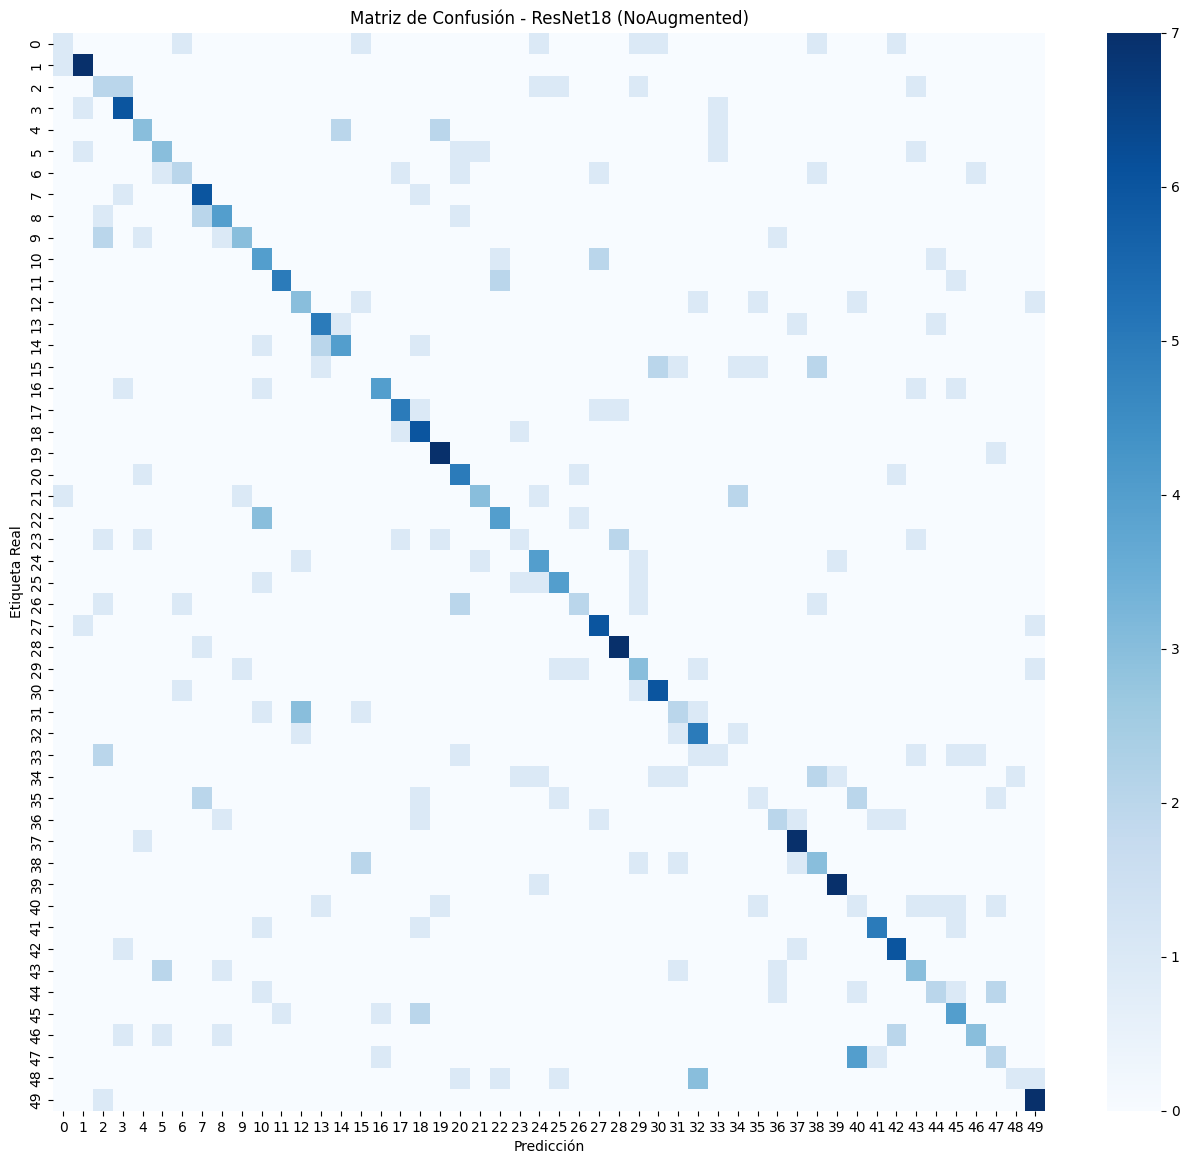

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,46.75
test_auc,91.77934
test_f1,44.66055
test_loss,2.39051
test_prec,45.3809


In [42]:
resultados_test = evaluar_experimento_ResNet18(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 2

In [43]:
# Configuración de Hiperparámetros
config = getConfig(1)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_ResNet18(
	config=config,
	train_dataset=train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=False,
	num_prueba=2
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 64
epochs: 100
alpha: 0.0001
weight_decay: 5e-05
dropout: 0.25
patience: 15

Época [1/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 7.2477 | Acc: 6.17% | Prec: 7.75% | Rec: 6.17% | F1: 5.70% | AUC: 64.44%
  Validación    -> Pérdida: 6.6606 | Acc: 1.50% | Prec: 0.13% | Rec: 1.50% | F1: 0.25% | AUC: 63.79%

Época [2/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 4.2040 | Acc: 18.50% | Prec: 20.57% | Rec: 18.50% | F1: 18.40% | AUC: 80.70%
  Validación    -> Pérdida: 5.1250 | Acc: 9.00% | Prec: 8.23% | Rec: 9.00% | F1: 4.94% | AUC: 78.86%

Época [3/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 2.9694 | Acc: 30.33% | Prec: 31.25% | Rec: 30.33% | F1: 29.98% | AUC: 88.47%
  Validación    -> Pérdida: 2.9516 | Acc: 28.25% | Prec: 33.71% | Rec: 28.25% | F1: 24.93% | AUC: 89.64%

Época [4/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 2.1459 | Acc: 44.75% | Prec: 45.70% | Rec: 44.75% | F1: 44.49% | AUC: 93.97%
  Validación

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
lr,████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▄▅▆▆▆▇▇▇▇▇███████████████
train_auc,▁▄▆▇▇███████████████████████
train_f1,▁▂▃▄▅▆▆▆▇▇▇▇▇███████████████
train_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▃▄▅▆▆▇▇▇▇▇▇███████████████
train_rec,▁▂▃▄▅▆▆▆▇▇▇▇▇███████████████
validation_acc,▁▂▅▅▆▇▇▇█▇███████▇██████████
validation_auc,▁▄▇▇▇███████████████████████
+4,...


#### Resultados de la Prueba 2


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 2.3418
Precisión (Acc): 46.00%
Precision: 45.24%
Recall: 46.00%
F1-Score: 43.97%
AUC: 92.67%



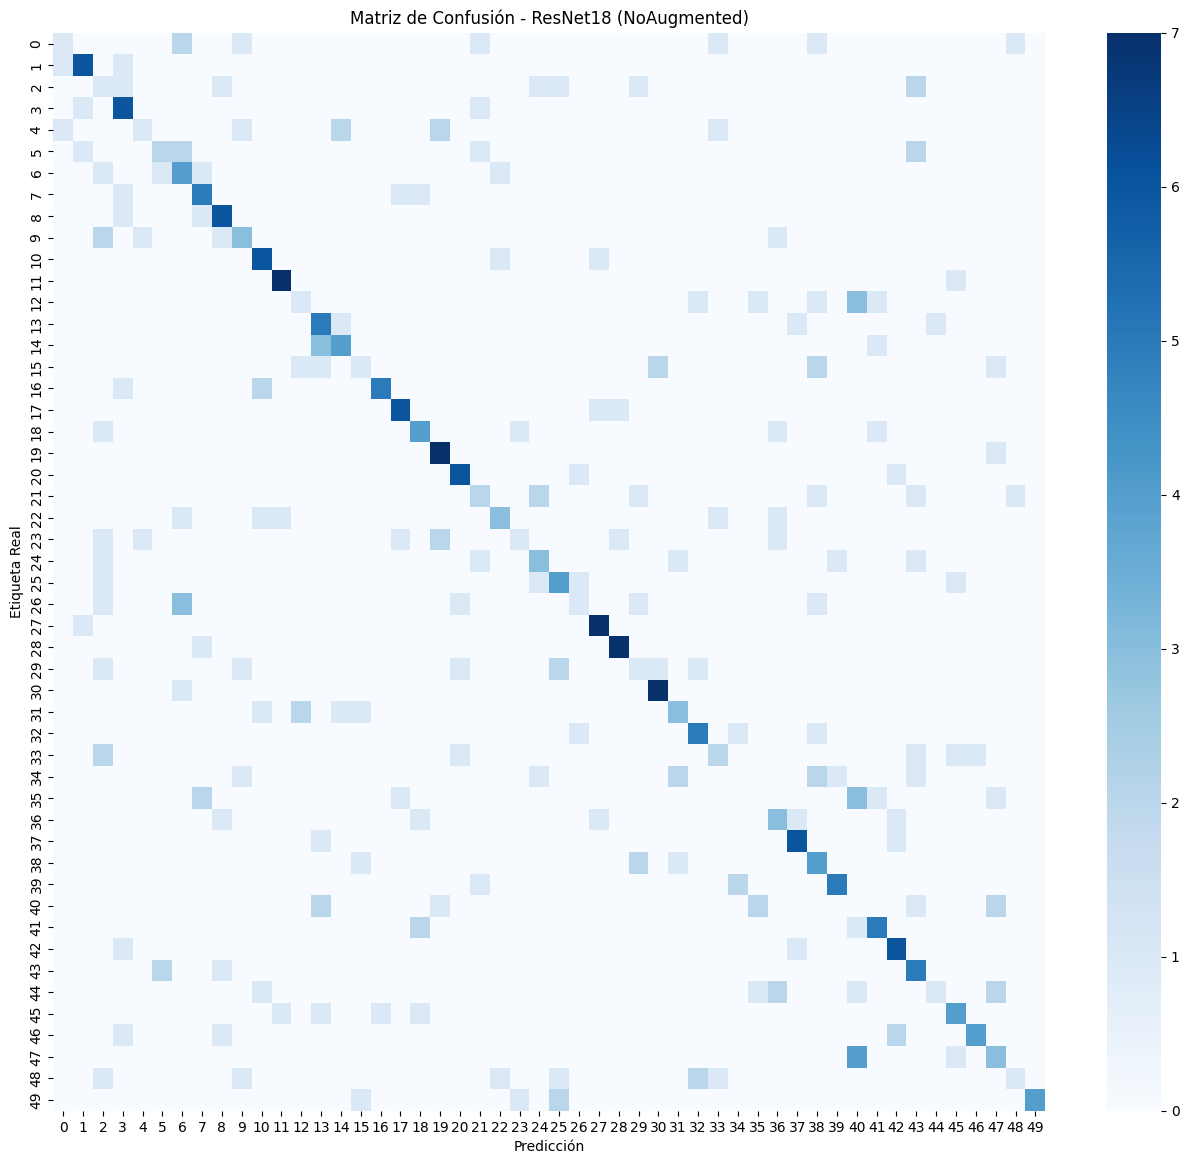

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,46
test_auc,92.67411
test_f1,43.9706
test_loss,2.3418
test_prec,45.2433


In [44]:
resultados_test = evaluar_experimento_ResNet18(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 3

In [45]:
# Configuración de Hiperparámetros
config = getConfig(2)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_ResNet18(
	config=config,
	train_dataset=train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=False,
	num_prueba=3
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 64
epochs: 120
alpha: 0.0005
weight_decay: 0.0001
dropout: 0.3
patience: 15

Época [1/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 6.4619 | Acc: 6.75% | Prec: 7.93% | Rec: 6.75% | F1: 6.79% | AUC: 63.30%
  Validación    -> Pérdida: 9.9110 | Acc: 3.25% | Prec: 0.38% | Rec: 3.25% | F1: 0.62% | AUC: 52.40%

Época [2/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 3.7370 | Acc: 15.92% | Prec: 16.22% | Rec: 15.92% | F1: 15.30% | AUC: 79.87%
  Validación    -> Pérdida: 3.6619 | Acc: 13.50% | Prec: 15.08% | Rec: 13.50% | F1: 9.29% | AUC: 80.01%

Época [3/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 3.3170 | Acc: 24.17% | Prec: 23.15% | Rec: 24.17% | F1: 23.18% | AUC: 85.38%
  Validación    -> Pérdida: 2.4032 | Acc: 35.00% | Prec: 36.43% | Rec: 35.00% | F1: 31.07% | AUC: 91.49%

Época [4/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 2.7932 | Acc: 32.42% | Prec: 32.44% | Rec: 32.42% | F1: 31.75% | AUC: 89.88%
  Validac

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
lr,████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train_acc,▁▂▂▃▄▅▅▆▆▆▇▇▇▇████████████
train_auc,▁▄▅▆▇▇▇███████████████████
train_f1,▁▂▂▃▄▅▅▆▆▆▇▇▇▇████████████
train_loss,█▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▂▃▄▅▅▆▆▆▇▇▇▇████████████
train_rec,▁▂▂▃▄▅▅▆▆▆▇▇▇▇████████████
validation_acc,▁▂▅▅▅▇▇▇▇▇█▇▇▇▇▇██████████
validation_auc,▁▅▇▇▇█████████████████████
+4,...


#### Resultados de la Prueba 3


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 2.0215
Precisión (Acc): 54.50%
Precision: 54.94%
Recall: 54.50%
F1-Score: 52.18%
AUC: 95.36%



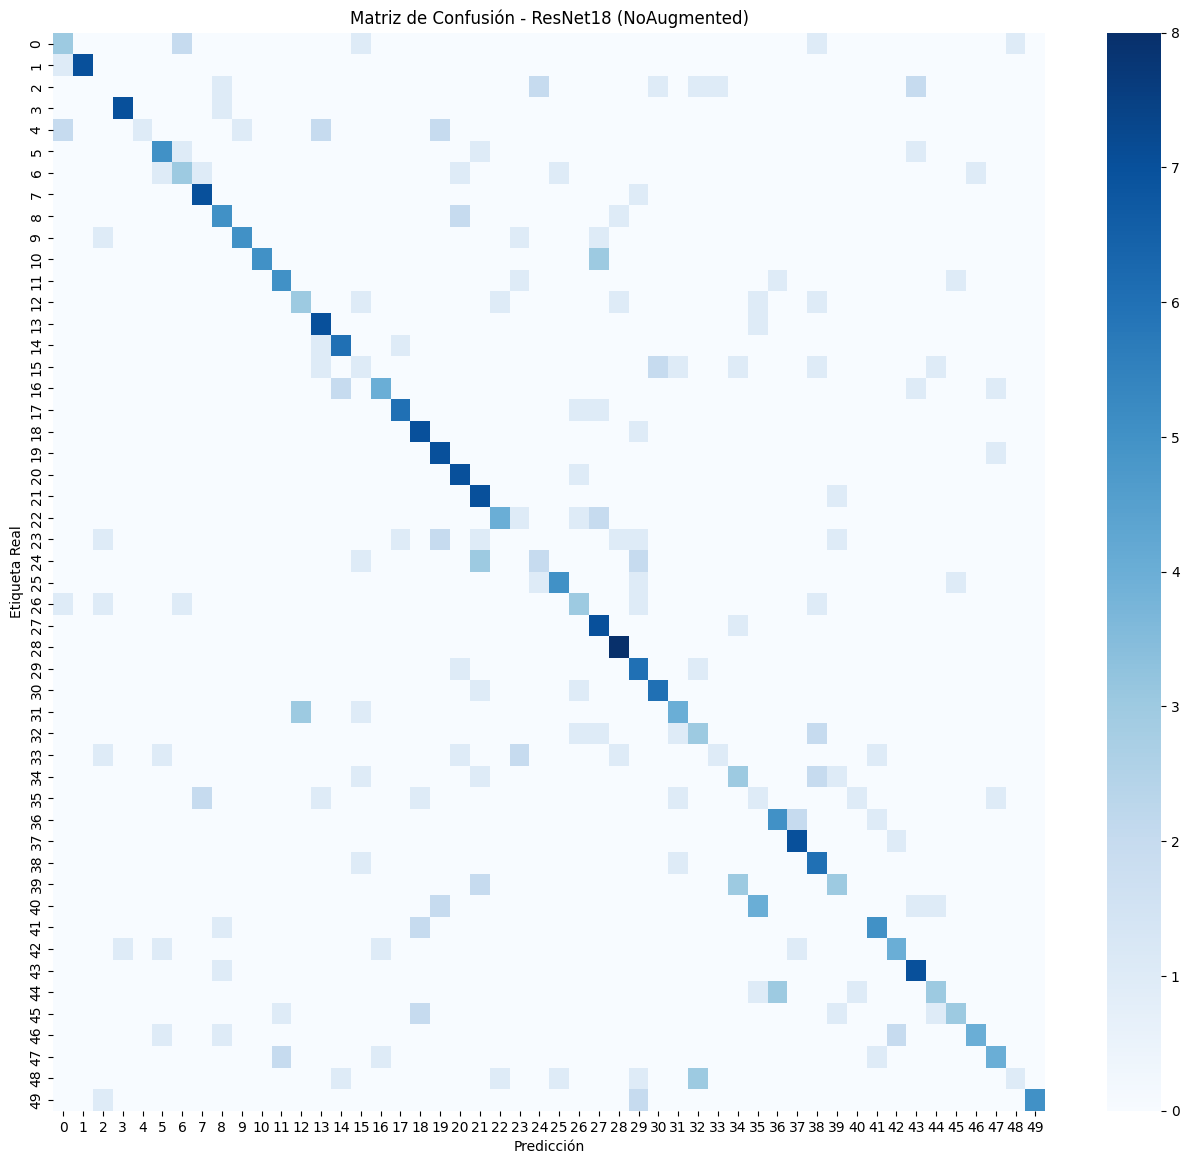

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,54.5
test_auc,95.35587
test_f1,52.17616
test_loss,2.02153
test_prec,54.93605


In [46]:
resultados_test = evaluar_experimento_ResNet18(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 4

In [47]:
# Configuración de Hiperparámetros
config = getConfig(3)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_ResNet18(
	config=config,
	train_dataset=train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=False,
	num_prueba=4
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 64
epochs: 120
alpha: 0.0002
weight_decay: 0.0002
dropout: 0.35
patience: 15

Época [1/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 7.4947 | Acc: 6.83% | Prec: 8.52% | Rec: 6.83% | F1: 6.49% | AUC: 65.18%
  Validación    -> Pérdida: 7.1993 | Acc: 1.75% | Prec: 0.13% | Rec: 1.75% | F1: 0.24% | AUC: 63.85%

Época [2/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 4.4760 | Acc: 17.00% | Prec: 18.19% | Rec: 17.00% | F1: 16.96% | AUC: 79.44%
  Validación    -> Pérdida: 4.7420 | Acc: 8.50% | Prec: 9.34% | Rec: 8.50% | F1: 4.45% | AUC: 78.22%

Época [3/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 3.3595 | Acc: 27.17% | Prec: 26.76% | Rec: 27.17% | F1: 26.55% | AUC: 86.62%
  Validación    -> Pérdida: 2.6709 | Acc: 30.25% | Prec: 30.25% | Rec: 30.25% | F1: 26.38% | AUC: 91.81%

Época [4/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 2.4614 | Acc: 38.50% | Prec: 38.84% | Rec: 38.50% | F1: 38.03% | AUC: 91.95%
  Validació

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
lr,████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▃▄▅▅▆▆▇▇▇▇███████████████████████
train_auc,▁▄▅▆▇▇██████████████████████████████
train_f1,▁▂▃▃▄▅▅▆▆▇▇▇▇███████████████████████
train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▂▃▄▅▆▆▆▇▇▇▇███████████████████████
train_rec,▁▂▃▃▄▅▅▆▆▇▇▇▇███████████████████████
validation_acc,▁▂▄▆▆▇▇▇▇▇▇▇▇▇████▇█████████████████
validation_auc,▁▄▇▇▇███████████████████████████████
+4,...


#### Resultados de la Prueba 4


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 2.3006
Precisión (Acc): 53.00%
Precision: 52.41%
Recall: 53.00%
F1-Score: 51.05%
AUC: 93.83%



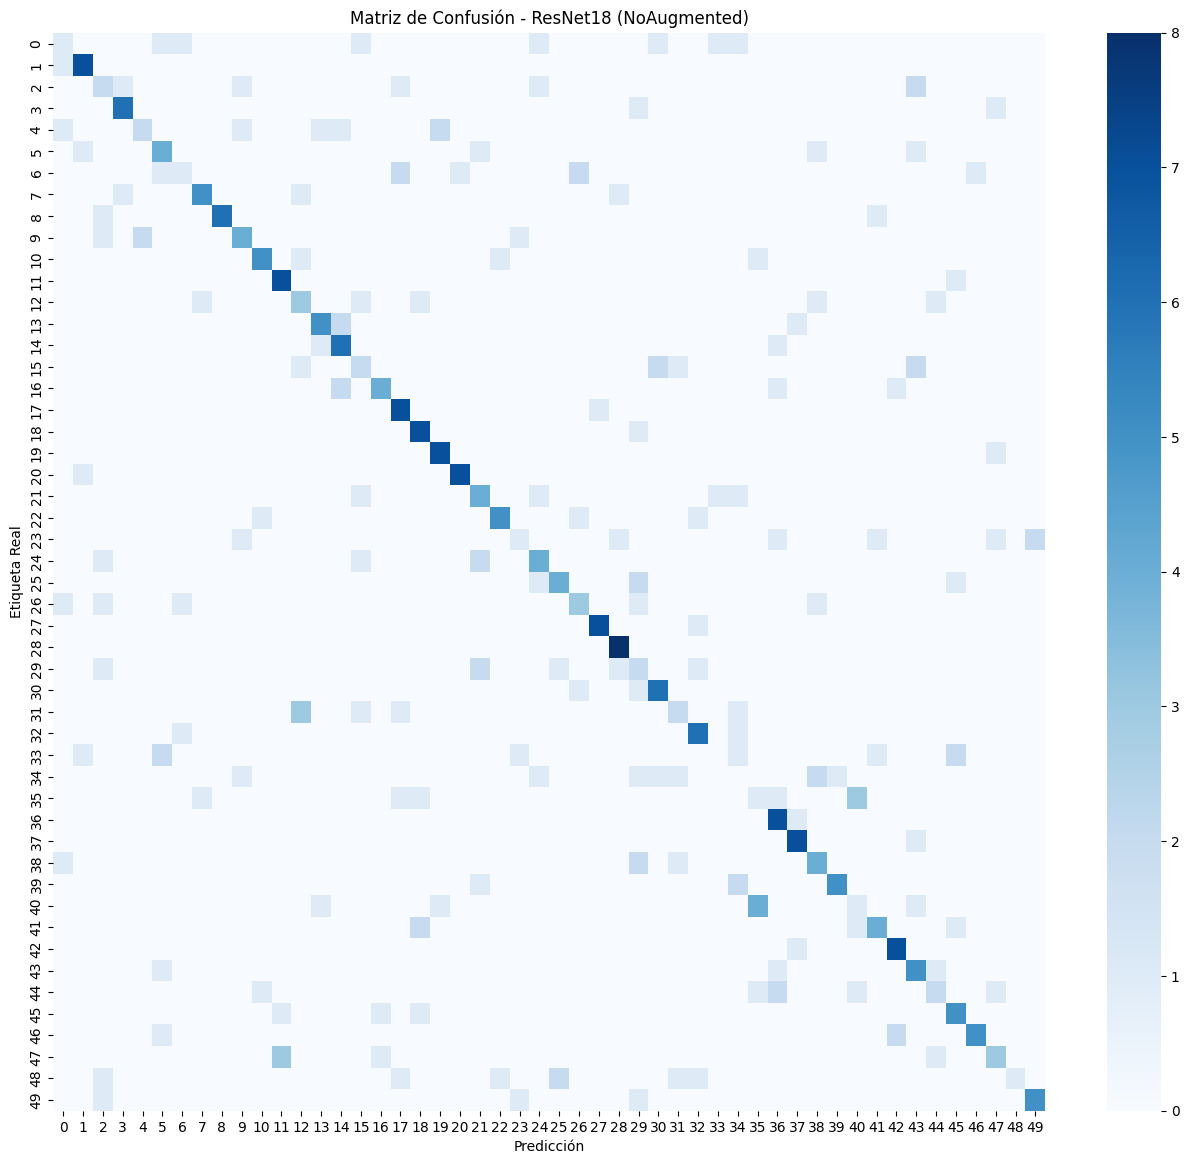

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,53
test_auc,93.83291
test_f1,51.05266
test_loss,2.30059
test_prec,52.40542


In [48]:
resultados_test = evaluar_experimento_ResNet18(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 5

In [49]:
# Configuración de Hiperparámetros
config = getConfig(4)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_ResNet18(
	config=config,
	train_dataset=train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=False,
	num_prueba=5
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 32
epochs: 60
alpha: 7.5e-05
weight_decay: 5e-05
dropout: 0.3
patience: 15

Época [1/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 7.4696 | Acc: 4.83% | Prec: 6.62% | Rec: 4.83% | F1: 4.81% | AUC: 63.52%
  Validación    -> Pérdida: 5.7944 | Acc: 4.50% | Prec: 0.45% | Rec: 4.50% | F1: 0.80% | AUC: 72.72%

Época [2/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 4.5234 | Acc: 14.92% | Prec: 15.73% | Rec: 14.92% | F1: 14.64% | AUC: 78.35%
  Validación    -> Pérdida: 3.4682 | Acc: 27.50% | Prec: 27.40% | Rec: 27.50% | F1: 23.29% | AUC: 84.98%

Época [3/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 3.2850 | Acc: 26.75% | Prec: 27.30% | Rec: 26.75% | F1: 26.52% | AUC: 86.69%
  Validación    -> Pérdida: 3.3473 | Acc: 33.75% | Prec: 37.87% | Rec: 33.75% | F1: 29.72% | AUC: 85.52%

Época [4/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 2.6079 | Acc: 37.58% | Prec: 38.39% | Rec: 37.58% | F1: 37.39% | AUC: 91.76%
  Validación 

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▄▄▅▆▆▆▆▇▇▇▇█▇███████████████████████
train_auc,▁▄▅▆▇▇█████████████████████████████████
train_f1,▁▂▃▄▄▅▆▆▆▆▇▇▇▇█▇███████████████████████
train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▃▃▄▅▆▆▆▆▇▇▇▇█▇███████████████████████
train_rec,▁▂▃▄▄▅▆▆▆▆▇▇▇▇█▇███████████████████████
validation_acc,▁▄▅▅▅▆▇▇▇▇█▇▇▇████▇████████████████████
validation_auc,▁▅▅▆▆▇▇████████████████████████████████
+4,...


#### Resultados de la Prueba 5


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 2.3728
Precisión (Acc): 48.00%
Precision: 47.17%
Recall: 48.00%
F1-Score: 46.04%
AUC: 92.47%



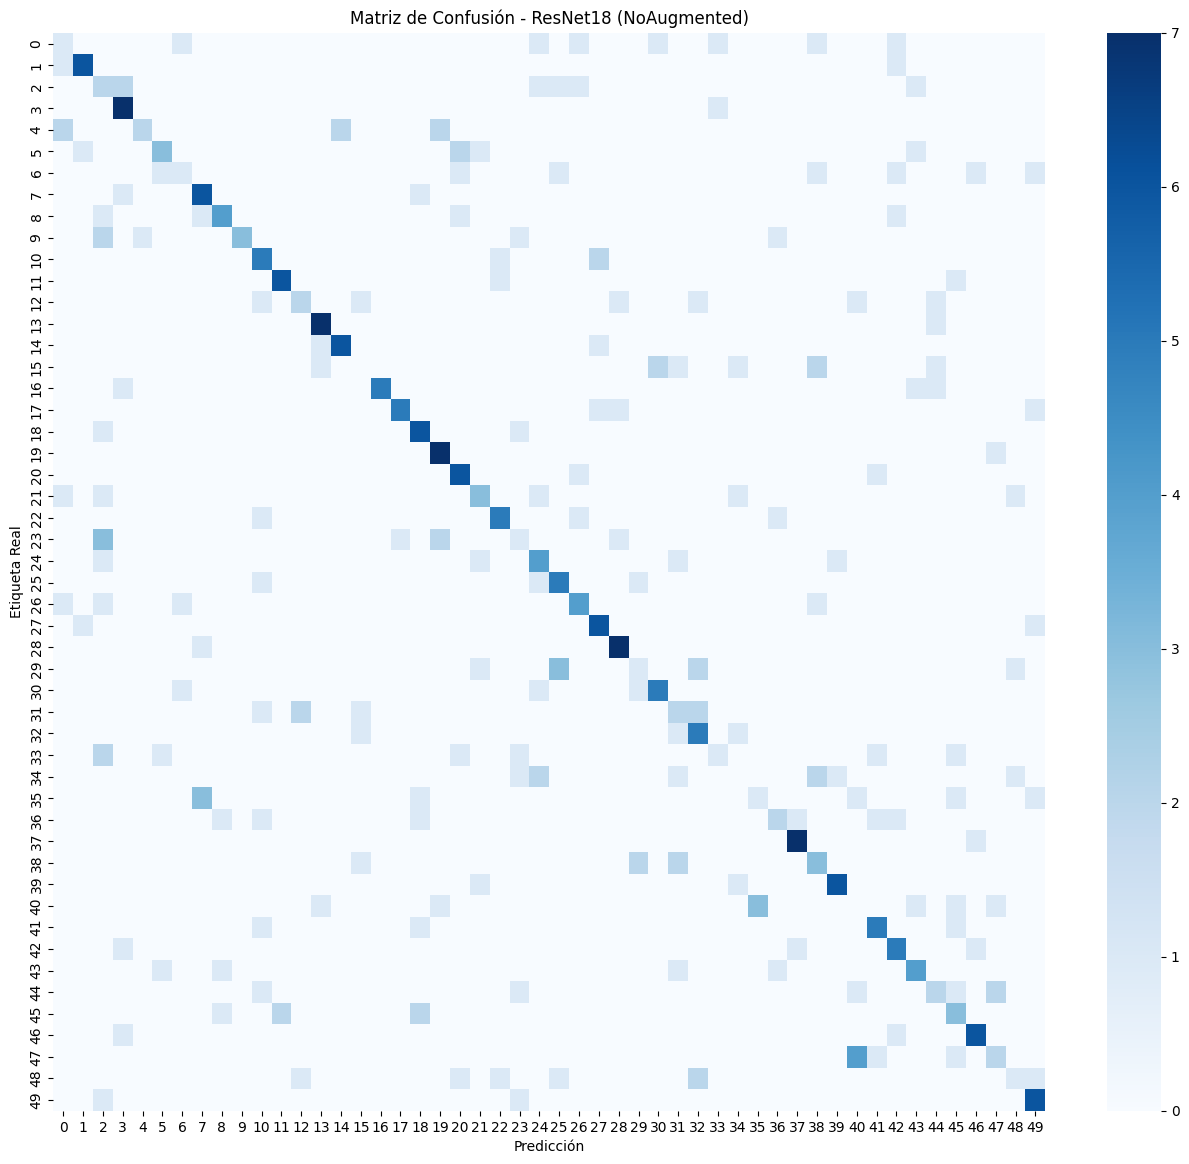

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,48
test_auc,92.46811
test_f1,46.04486
test_loss,2.37282
test_prec,47.16769


In [50]:
resultados_test = evaluar_experimento_ResNet18(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

### Pruebas con el Dataset Augmentado

In [51]:
# Configuración del Dataset
augmented_train_dataset = AudioSpectrogramDataset(augmented_training_set, augmented=True)
val_dataset = AudioSpectrogramDataset(validation_set, augmented=False)
test_dataset = AudioSpectrogramDataset(testing_set, augmented=False)

#### Ejecución de la Prueba 1

In [52]:
# Configuración de Hiperparámetros
config = getConfig(0)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_ResNet18(
	config=config,
	train_dataset=augmented_train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=True,
	num_prueba=1
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 32
epochs: 80
alpha: 5e-05
weight_decay: 1e-05
dropout: 0.3
patience: 15

Época [1/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 6.5884 | Acc: 4.47% | Prec: 6.03% | Rec: 4.47% | F1: 4.32% | AUC: 61.20%
  Validación    -> Pérdida: 5.6140 | Acc: 13.75% | Prec: 13.75% | Rec: 13.75% | F1: 10.68% | AUC: 72.98%

Época [2/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 4.1576 | Acc: 12.31% | Prec: 12.29% | Rec: 12.31% | F1: 12.05% | AUC: 75.13%
  Validación    -> Pérdida: 4.6292 | Acc: 22.50% | Prec: 21.42% | Rec: 22.50% | F1: 19.19% | AUC: 81.01%

Época [3/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 3.3889 | Acc: 18.83% | Prec: 18.58% | Rec: 18.83% | F1: 18.45% | AUC: 83.00%
  Validación    -> Pérdida: 3.0907 | Acc: 28.25% | Prec: 30.53% | Rec: 28.25% | F1: 24.75% | AUC: 88.45%

Época [4/80], Lr: 0.000050
  Entrenamiento -> Pérdida: 2.7807 | Acc: 30.97% | Prec: 31.02% | Rec: 30.97% | F1: 30.79% | AUC: 88.56%
  Validació

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
lr,████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▂▃▄▅▅▆▆▇▇▇▇▇▇█████████████████████
train_auc,▁▄▅▆▇▇██████████████████████████████
train_f1,▁▂▂▃▄▅▅▆▆▇▇▇▇▇▇█████████████████████
train_loss,█▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▁▂▃▄▅▅▆▆▇▇▇▇▇▇█████████████████████
train_rec,▁▂▂▃▄▅▅▆▆▇▇▇▇▇▇█████████████████████
validation_acc,▁▂▃▄▆▇▇▇▇▇▇▇▇▇█▇███▇▇▇███▇█▇▇█▇█████
validation_auc,▁▃▆▆▇▇▇▇████████████████████████████
+4,...


#### Resultados de la Prueba 1


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 3.0708
Precisión (Acc): 48.50%
Precision: 49.04%
Recall: 48.50%
F1-Score: 46.21%
AUC: 93.36%



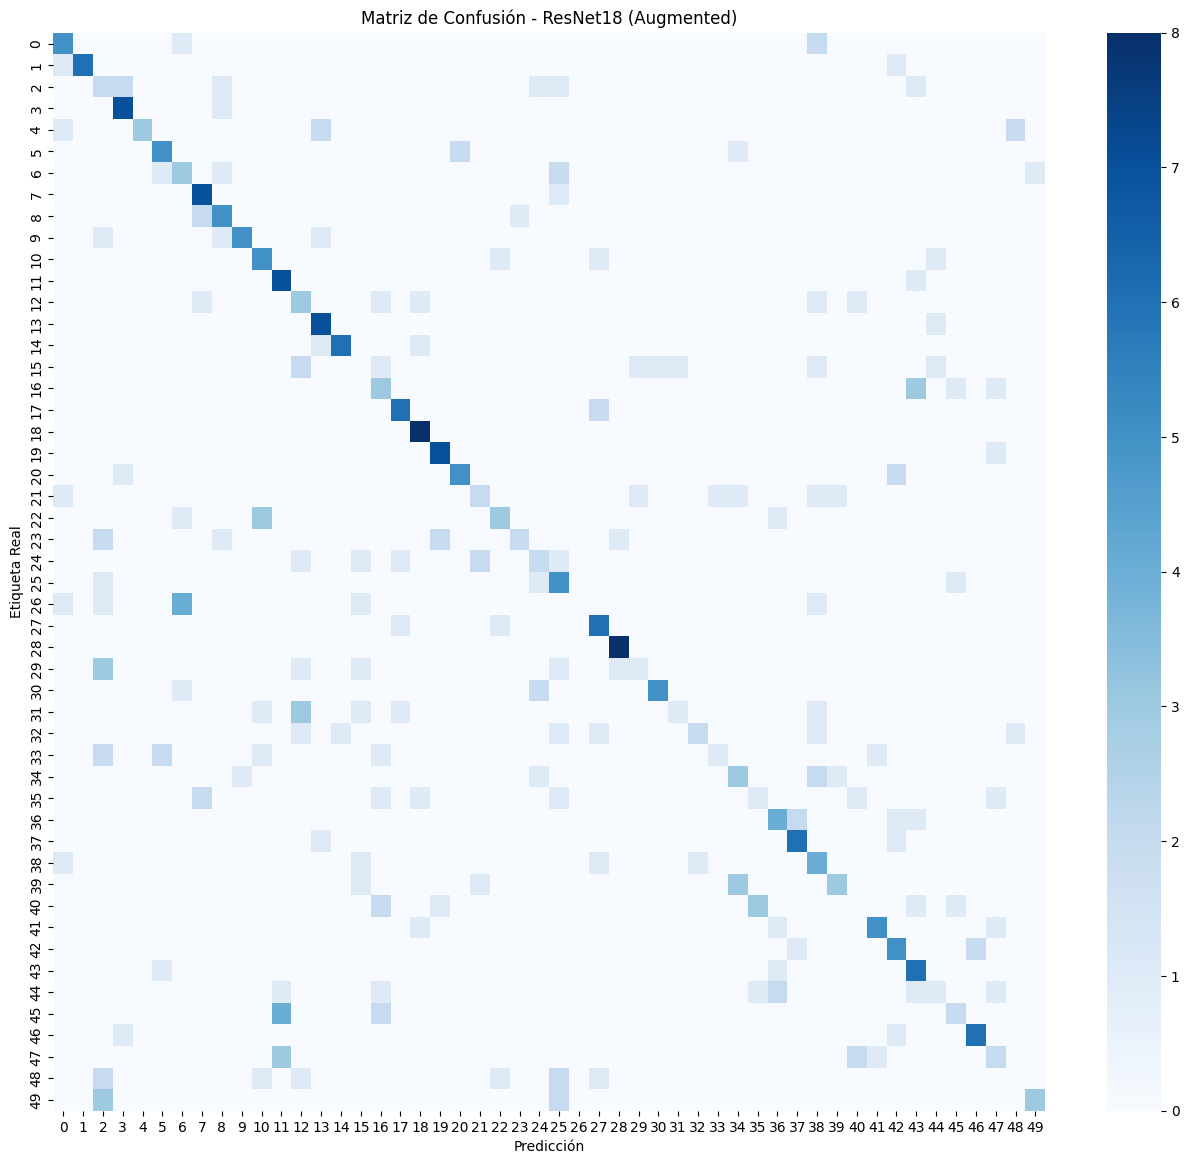

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,48.5
test_auc,93.35651
test_f1,46.21379
test_loss,3.07081
test_prec,49.04063


In [53]:
resultados_test = evaluar_experimento_ResNet18(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 2

In [54]:
# Configuración de Hiperparámetros
config = getConfig(1)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_ResNet18(
	config=config,
	train_dataset=augmented_train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=True,
	num_prueba=2
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 64
epochs: 100
alpha: 0.0001
weight_decay: 5e-05
dropout: 0.25
patience: 15

Época [1/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 5.9289 | Acc: 6.06% | Prec: 6.89% | Rec: 6.06% | F1: 5.88% | AUC: 63.02%
  Validación    -> Pérdida: 4.4481 | Acc: 13.00% | Prec: 16.28% | Rec: 13.00% | F1: 10.43% | AUC: 78.79%

Época [2/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 3.6666 | Acc: 16.19% | Prec: 15.93% | Rec: 16.19% | F1: 15.79% | AUC: 80.15%
  Validación    -> Pérdida: 4.0889 | Acc: 22.50% | Prec: 25.70% | Rec: 22.50% | F1: 18.76% | AUC: 84.36%

Época [3/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 2.7770 | Acc: 30.78% | Prec: 30.67% | Rec: 30.78% | F1: 30.38% | AUC: 88.60%
  Validación    -> Pérdida: 2.6740 | Acc: 35.00% | Prec: 38.72% | Rec: 35.00% | F1: 32.32% | AUC: 91.13%

Época [4/100], Lr: 0.000100
  Entrenamiento -> Pérdida: 2.1095 | Acc: 42.89% | Prec: 43.06% | Rec: 42.89% | F1: 42.74% | AUC: 93.58%
  Va

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
lr,████▄▄▄▄▄▂▂▂▂▂▁▁▁▁▁▁▁
train_acc,▁▂▃▄▅▆▆▇▇▇███████████
train_auc,▁▄▆▇▇████████████████
train_f1,▁▂▃▄▅▆▆▇▇▇███████████
train_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▃▄▅▆▆▇▇▇███████████
train_rec,▁▂▃▄▅▆▆▇▇▇███████████
validation_acc,▁▃▅▆▆▇▇▇▆█▇▇█████████
validation_auc,▁▃▆▅▇██▇▇████████████
+4,...


#### Resultados de la Prueba 2


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 2.9104
Precisión (Acc): 49.25%
Precision: 55.40%
Recall: 49.25%
F1-Score: 47.54%
AUC: 93.13%



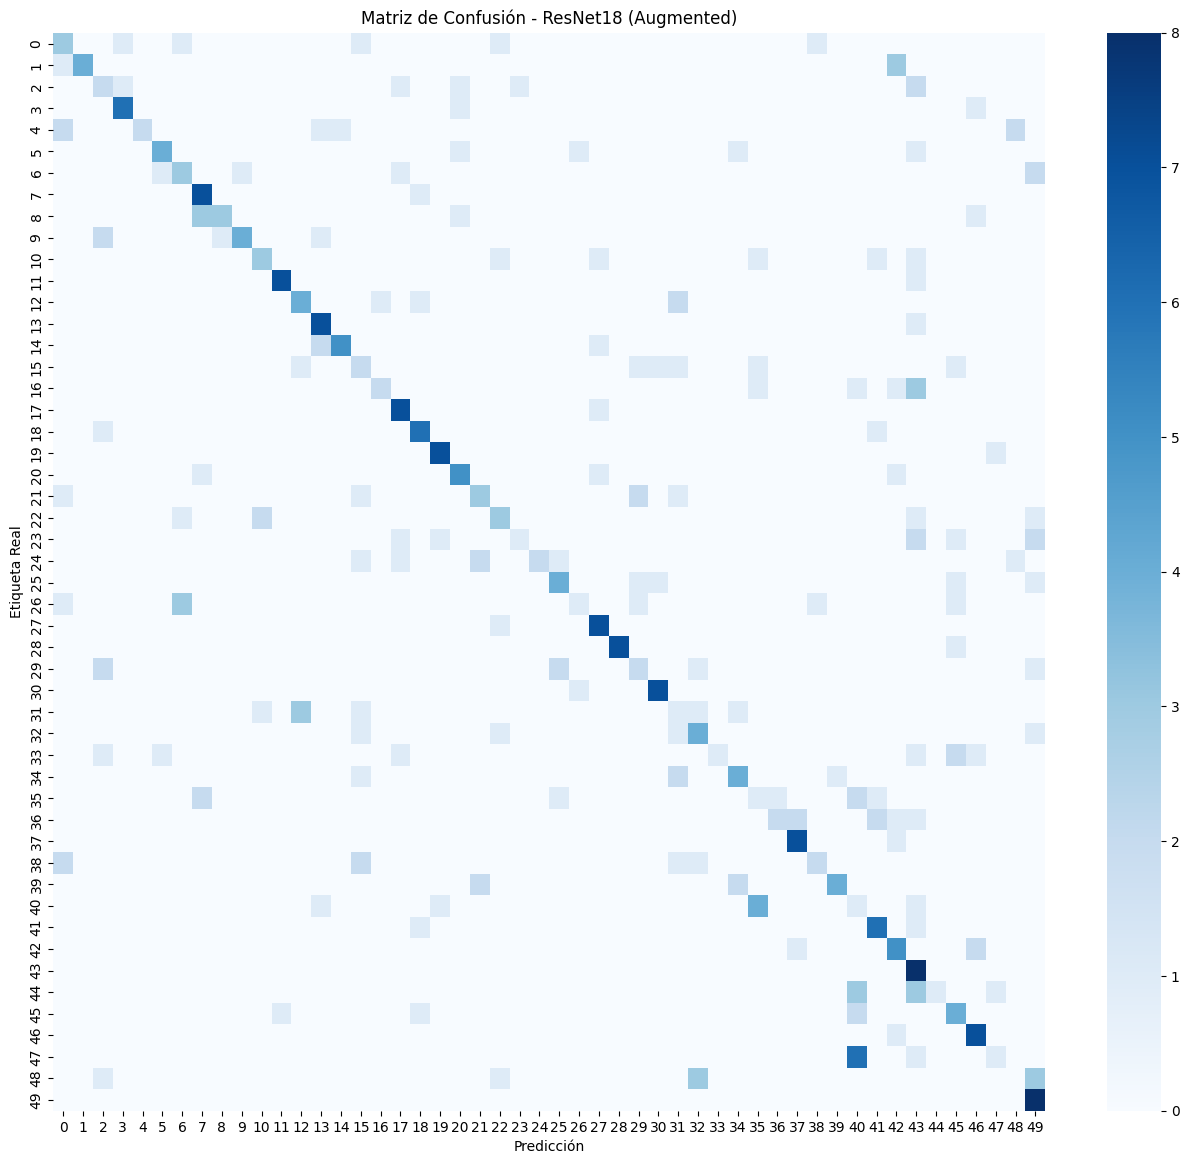

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,49.25
test_auc,93.13393
test_f1,47.53883
test_loss,2.91044
test_prec,55.40139


In [55]:
resultados_test = evaluar_experimento_ResNet18(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 3

In [56]:
# Configuración de Hiperparámetros
config = getConfig(2)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_ResNet18(
	config=config,
	train_dataset=augmented_train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=True,
	num_prueba=3
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 64
epochs: 120
alpha: 0.0005
weight_decay: 0.0001
dropout: 0.3
patience: 15

Época [1/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 5.0850 | Acc: 8.31% | Prec: 8.38% | Rec: 8.31% | F1: 8.10% | AUC: 64.83%
  Validación    -> Pérdida: 3.7001 | Acc: 15.75% | Prec: 15.76% | Rec: 15.75% | F1: 12.67% | AUC: 82.01%

Época [2/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 3.3921 | Acc: 19.89% | Prec: 19.32% | Rec: 19.89% | F1: 19.34% | AUC: 82.74%
  Validación    -> Pérdida: 2.9710 | Acc: 34.75% | Prec: 39.85% | Rec: 34.75% | F1: 30.57% | AUC: 90.57%

Época [3/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 2.6383 | Acc: 32.58% | Prec: 31.81% | Rec: 32.58% | F1: 31.88% | AUC: 89.94%
  Validación    -> Pérdida: 5.7603 | Acc: 30.75% | Prec: 36.33% | Rec: 30.75% | F1: 27.19% | AUC: 83.79%

Sin mejora por 1 épocas consecutivas.
Época [4/120], Lr: 0.000500
  Entrenamiento -> Pérdida: 2.1513 | Acc: 42.75% | Prec: 42.63% | Rec: 

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
lr,████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▄▄▅▆▆▇▇▇██████████████████████
train_auc,▁▅▆▇▇████████████████████████████
train_f1,▁▂▃▄▄▅▆▆▇▇▇██████████████████████
train_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▃▄▄▅▆▆▇▇▇██████████████████████
train_rec,▁▂▃▄▄▅▆▆▇▇▇██████████████████████
validation_acc,▁▄▃▅▄▇▆▆▇▇▇▇▇████████████████████
validation_auc,▁▅▂▆▆▇▇▇▇████████████████████████
+4,...


#### Resultados de la Prueba 3


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 2.7979
Precisión (Acc): 61.75%
Precision: 61.71%
Recall: 61.75%
F1-Score: 59.60%
AUC: 95.97%



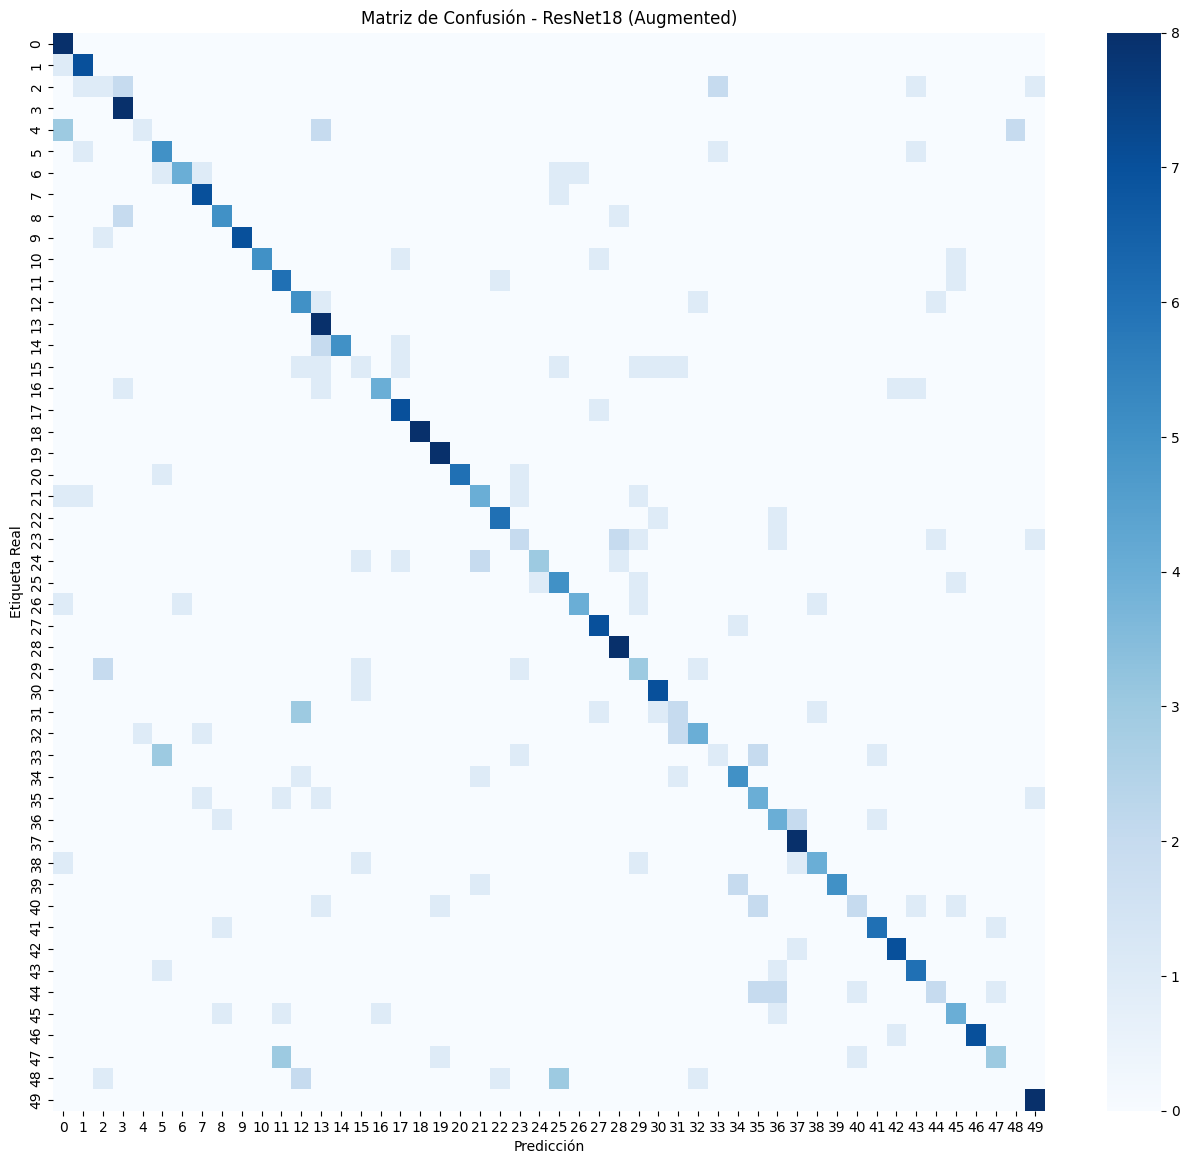

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,61.75
test_auc,95.97321
test_f1,59.5983
test_loss,2.79787
test_prec,61.70672


In [57]:
resultados_test = evaluar_experimento_ResNet18(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 4

In [58]:
# Configuración de Hiperparámetros
config = getConfig(3)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_ResNet18(
	config=config,
	train_dataset=augmented_train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=True,
	num_prueba=4
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 64
epochs: 120
alpha: 0.0002
weight_decay: 0.0002
dropout: 0.35
patience: 15

Época [1/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 5.8728 | Acc: 6.19% | Prec: 6.84% | Rec: 6.19% | F1: 6.15% | AUC: 62.08%
  Validación    -> Pérdida: 4.0918 | Acc: 11.25% | Prec: 11.74% | Rec: 11.25% | F1: 8.73% | AUC: 76.56%

Época [2/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 3.7410 | Acc: 15.03% | Prec: 14.72% | Rec: 15.03% | F1: 14.64% | AUC: 78.91%
  Validación    -> Pérdida: 3.5313 | Acc: 23.25% | Prec: 25.81% | Rec: 23.25% | F1: 18.23% | AUC: 86.03%

Época [3/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 2.9586 | Acc: 27.25% | Prec: 26.74% | Rec: 27.25% | F1: 26.54% | AUC: 87.13%
  Validación    -> Pérdida: 3.9366 | Acc: 35.50% | Prec: 39.67% | Rec: 35.50% | F1: 32.46% | AUC: 87.95%

Sin mejora por 1 épocas consecutivas.
Época [4/120], Lr: 0.000200
  Entrenamiento -> Pérdida: 2.4296 | Acc: 36.92% | Prec: 36.56% | Rec: 

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
lr,████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▃▄▅▆▆▇▇▇██████████████████████
train_auc,▁▄▆▆▇▇███████████████████████████
train_f1,▁▂▃▃▄▅▆▆▇▇▇██████████████████████
train_loss,█▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▃▃▄▅▆▆▇▇▇██████████████████████
train_rec,▁▂▃▃▄▅▆▆▇▇▇██████████████████████
validation_acc,▁▃▄▅▆▆▆▆▆▅▇▇▇█▇███▇█▇████████████
validation_auc,▁▄▅▆▆▇▇▇▇▇███████████████████████
+4,...


#### Resultados de la Prueba 4


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 3.4737
Precisión (Acc): 54.75%
Precision: 55.73%
Recall: 54.75%
F1-Score: 52.63%
AUC: 94.20%



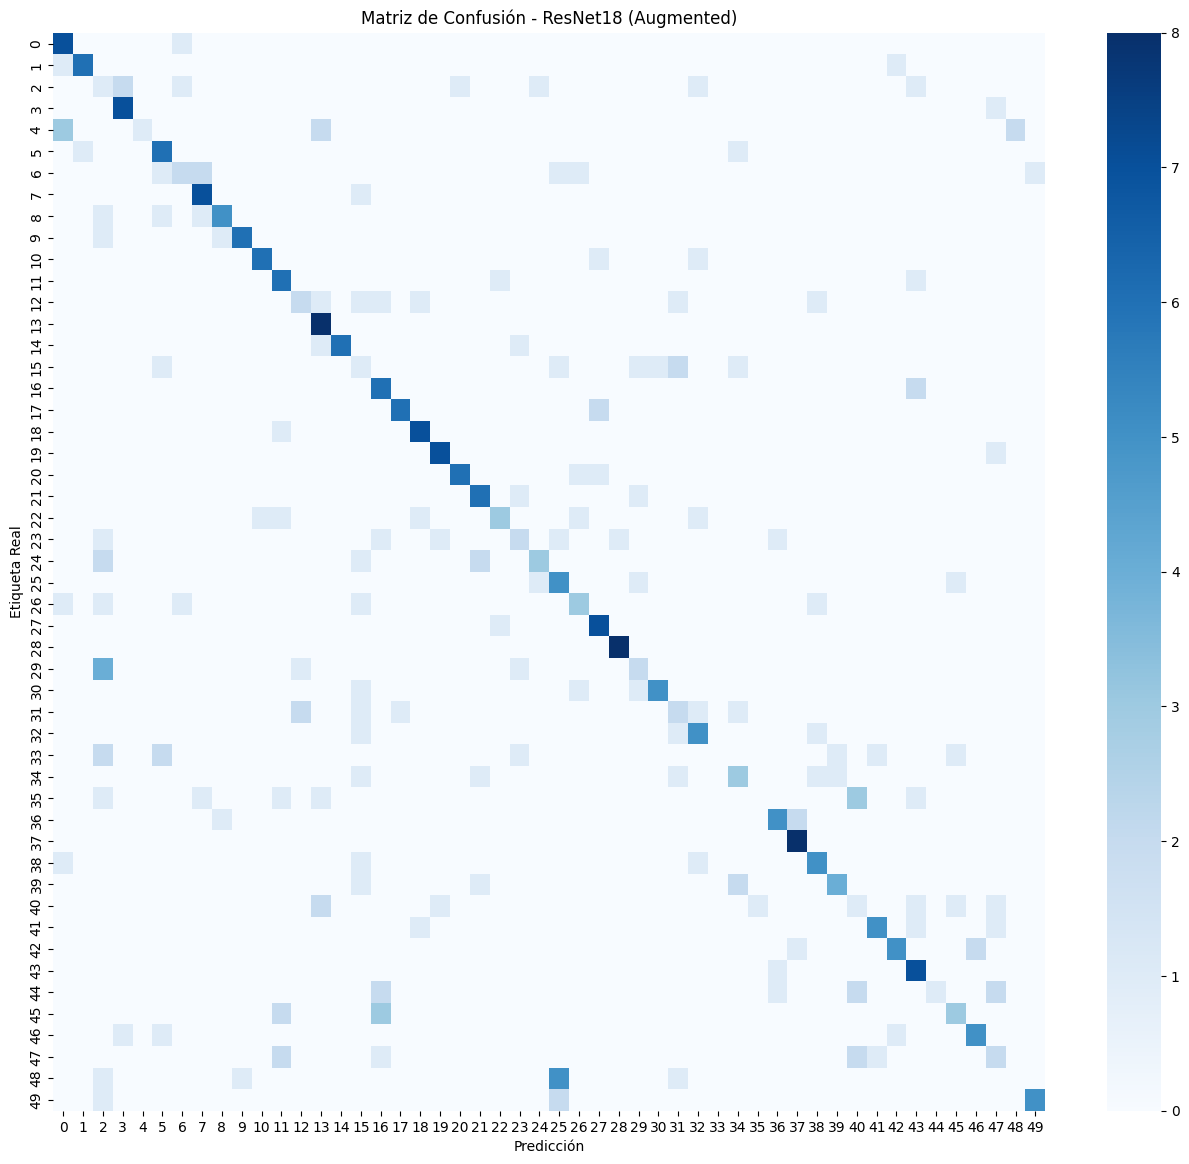

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,54.75
test_auc,94.20281
test_f1,52.63434
test_loss,3.47371
test_prec,55.7346


In [59]:
resultados_test = evaluar_experimento_ResNet18(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

#### Ejecución de la Prueba 5

In [60]:
# Configuración de Hiperparámetros
config = getConfig(4)

model, history, test_loader, criterion, dataset_type, num_prueba = ejecutar_experimento_ResNet18(
	config=config,
	train_dataset=augmented_train_dataset,
	val_dataset=val_dataset,
	test_dataset=test_dataset,
	augmentado=True,
	num_prueba=5
)

===== Hiperparámetros de configuración =====
num_classes: 50
batch_size: 32
epochs: 60
alpha: 7.5e-05
weight_decay: 5e-05
dropout: 0.3
patience: 15

Época [1/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 6.1235 | Acc: 5.64% | Prec: 7.32% | Rec: 5.64% | F1: 5.65% | AUC: 62.65%
  Validación    -> Pérdida: 5.9071 | Acc: 13.75% | Prec: 11.91% | Rec: 13.75% | F1: 10.62% | AUC: 74.12%

Época [2/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 3.8265 | Acc: 15.42% | Prec: 15.20% | Rec: 15.42% | F1: 15.07% | AUC: 78.28%
  Validación    -> Pérdida: 4.3221 | Acc: 24.50% | Prec: 25.44% | Rec: 24.50% | F1: 20.63% | AUC: 83.57%

Época [3/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 2.9943 | Acc: 25.53% | Prec: 25.28% | Rec: 25.53% | F1: 25.15% | AUC: 87.04%
  Validación    -> Pérdida: 2.9750 | Acc: 38.75% | Prec: 47.84% | Rec: 38.75% | F1: 37.10% | AUC: 90.01%

Época [4/60], Lr: 0.000075
  Entrenamiento -> Pérdida: 2.3603 | Acc: 39.31% | Prec: 39.27% | Rec: 39.31% | F1: 39.12% | AUC: 92.00%
  Validac

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
lr,████▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▂▄▆▇▇█████████████████████████████████
train_auc,▁▄▇▇████████████████████████████████████
train_f1,▁▄▅▆▆▇▇█████████████████████████████████
train_loss,█▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_prec,▁▂▂▃▅▇██████████████████████████████████
train_rec,▁▂▂▄▅▆▇▇▇███████████████████████████████
validation_acc,▁▃▅▆▇▇▇▇████████████████████████████████
validation_auc,▁▄▆▆▇███████████████████████████████████
+4,...


#### Resultados de la Prueba 5


Iniciando evaluación en conjunto de test

===== Resultados de Test =====
Pérdida: 3.2132
Precisión (Acc): 52.75%
Precision: 55.03%
Recall: 52.75%
F1-Score: 51.22%
AUC: 93.88%



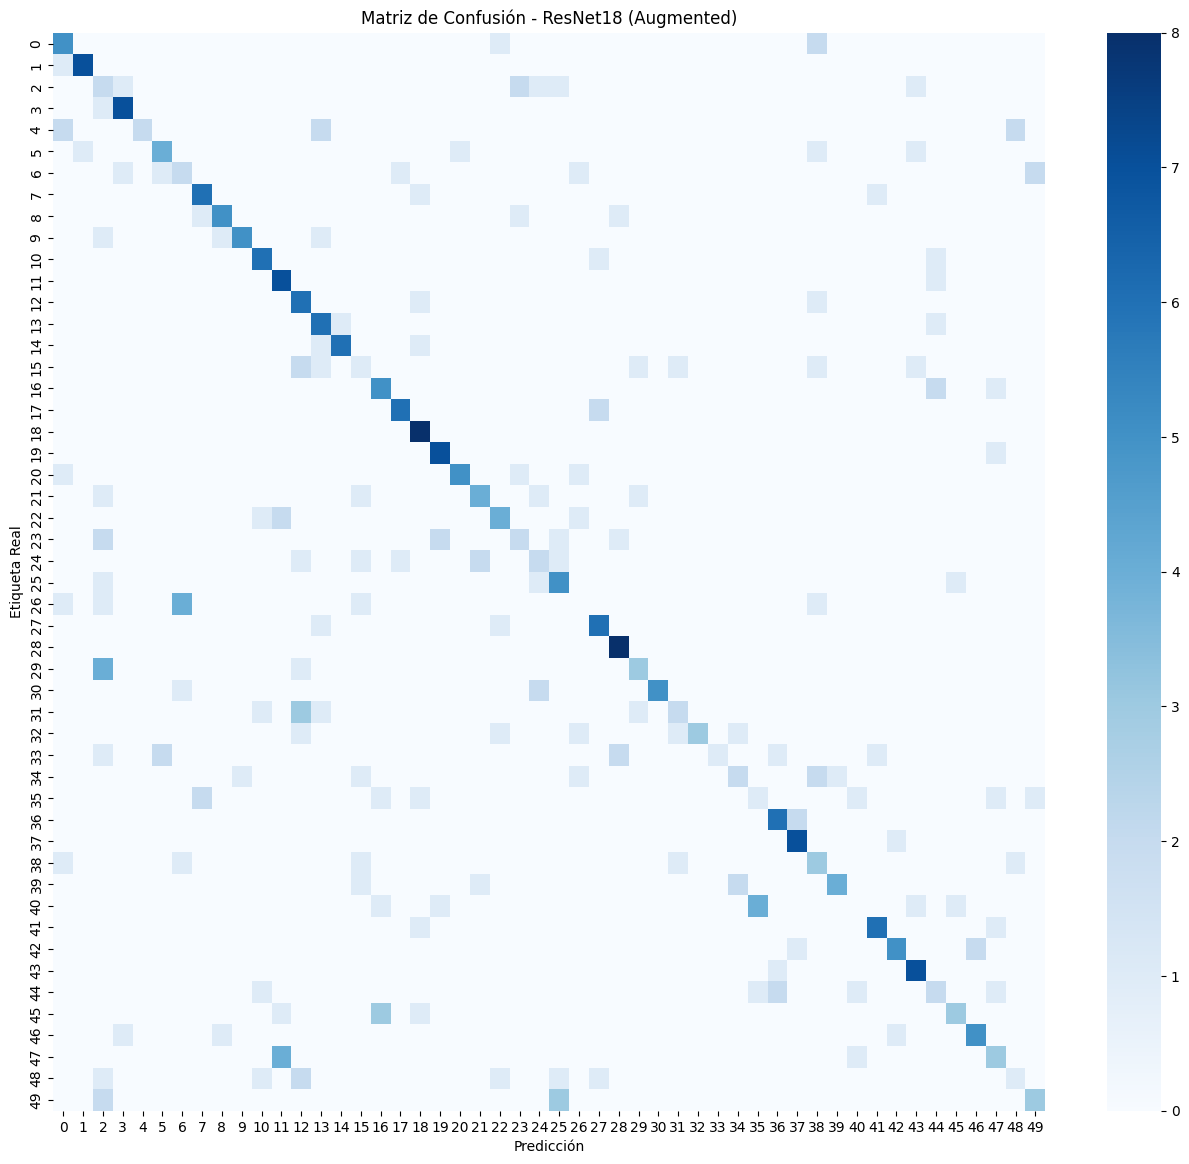

Resultados de test registrados en WandB y matriz de confusión mostrada.



test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
test_prec,▁
test_rec,▁
test_acc,52.75
test_auc,93.87883
test_f1,51.22457
test_loss,3.21323
test_prec,55.02612


In [61]:
resultados_test = evaluar_experimento_ResNet18(
	model=model,
	test_loader=test_loader,
	criterion=criterion,
	dataset_type=dataset_type,
	num_prueba=num_prueba
)

## Validación Final

In [62]:
best_model = torch.load("./Models/ResNet18_Augmented_3_Augmented_ResNet18.pth", map_location=device)
best_model.to(device)

def validar_imagen(model, img_path, true_label, class_names, device):
    """
    Evalúa una imagen individual con el modelo entrenado y muestra las top-5 predicciones.
    
    Parámetros:
        model: modelo CNN ya entrenado
        img_path: ruta al archivo de imagen (espectrograma)
        true_label: clase real (nombre o índice)
        class_names: lista de nombres de clases (ordenadas como en el entrenamiento)
        device: 'cuda' o 'cpu'
    """

    # Transformaciones coherentes con el entrenamiento
    transform = transforms.Compose([
        transforms.Resize((224, 224)),               # mismo tamaño que entrenamiento
        transforms.ToTensor(),                       # convertir a tensor [0,1]
        transforms.Normalize(mean=[0.5, 0.5, 0.5],   # normalizar igual
                             std=[0.5, 0.5, 0.5])
    ])

    # Cargar y preparar la imagen
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Inferencia
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)[0]
        top_probs, top_idxs = torch.topk(probs, k=5)

    # Mostrar resultados
    print(f"\nEvaluando: {img_path}")
    print(f"Clase real: {true_label}\n")
    print("Top-5 predicciones:")
    for i in range(5):
        clase = class_names[top_idxs[i].item()]
        prob = top_probs[i].item() * 100
        marca = "Correcta" if clase == true_label else ""
        print(f"{i+1:>2}. {clase:20s} → {prob:6.2f}% {marca}")

    # Posición real de la clase correcta
    true_idx = class_names.index(true_label)
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    rank_real = (sorted_indices == true_idx).nonzero(as_tuple=True)[0].item() + 1
    prob_real = probs[true_idx].item() * 100

    print(f"\n Probabilidad de la clase real ({true_label}): {prob_real:.2f}%")
    print(f" Posición en ranking: {rank_real}\n")

    return {
        "true_label": true_label,
        "prob_real": prob_real,
        "rank_real": rank_real,
        "top5_classes": [class_names[i] for i in top_idxs],
        "top5_probs": top_probs.tolist()
    }

img_path = "data/Images/5-9032-A-0.png"
true_label = "dog"
class_names = list(dataset.sort_values('target')['category'].unique())

resultado = validar_imagen(best_model, img_path, true_label, class_names, device)

img_path = "data/Images/5-235874-A-28.png"
true_label = "snoring"
class_names = list(dataset.sort_values('target')['category'].unique())

resultado = validar_imagen(best_model, img_path, true_label, class_names, device)

img_path = "data/Images/5-253085-B-3.png"
true_label = "cow"
class_names = list(dataset.sort_values('target')['category'].unique())

resultado = validar_imagen(best_model, img_path, true_label, class_names, device)

img_path = "data/Images/5-221567-A-22.png"
true_label = "clapping"
class_names = list(dataset.sort_values('target')['category'].unique())

resultado = validar_imagen(best_model, img_path, true_label, class_names, device)



Evaluando: data/Images/5-9032-A-0.png
Clase real: dog

Top-5 predicciones:
 1. dog                  →  65.01% Correcta
 2. crow                 →  12.99% 
 3. water_drops          →   9.99% 
 4. rooster              →   6.35% 
 5. frog                 →   5.15% 

 Probabilidad de la clase real (dog): 65.01%
 Posición en ranking: 1


Evaluando: data/Images/5-235874-A-28.png
Clase real: snoring

Top-5 predicciones:
 1. snoring              →  96.77% Correcta
 2. insects              →   3.14% 
 3. cow                  →   0.02% 
 4. pouring_water        →   0.02% 
 5. vacuum_cleaner       →   0.01% 

 Probabilidad de la clase real (snoring): 96.77%
 Posición en ranking: 1


Evaluando: data/Images/5-253085-B-3.png
Clase real: cow

Top-5 predicciones:
 1. cow                  →  99.84% Correcta
 2. church_bells         →   0.16% 
 3. siren                →   0.00% 
 4. crying_baby          →   0.00% 
 5. car_horn             →   0.00% 

 Probabilidad de la clase real (cow): 99.84%
 Posici

C:\Users\lfben\AppData\Local\Temp\ipykernel_36496\608073996.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("./Models/ResNet18_Augmented_3_Augmen

## Referencias

1. **Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner**,  
   *Gradient-Based Learning Applied to Document Recognition*,  
   *Proceedings of the IEEE*, vol. 86, no. 11, pp. 2278–2324, Nov. 1998.  

2. **C. Szegedy, W. Liu, Y. Jia, P. Sermanet, S. Reed, D. Anguelov, D. Erhan, V. Vanhoucke, and A. Rabinovich**,  
   *Going Deeper with Convolutions*,  
   *arXiv*, arXiv:1409.4842, 2014. [Online]. Disponible en: [https://arxiv.org/abs/1409.4842](https://arxiv.org/abs/1409.4842)

3. **A. H. Syed**,  
   *Hands-on Guide to LeNet-5 (The Complete Info)*,  
   *Medium*, 13 de marzo de 2023. [Online]. Disponible en: [https://syedabis98.medium.com/hands-on-guide-to-lenet-5-the-complete-info-b2ae631db34b](https://syedabis98.medium.com/hands-on-guide-to-lenet-5-the-complete-info-b2ae631db34b)

4. **K. He, X. Zhang, S. Ren, and J. Sun**,  
   *Deep Residual Learning for Image Recognition*,  
   *arXiv*, arXiv:1512.03385, 2015. [Online]. Disponible en: [https://arxiv.org/abs/1512.03385](https://arxiv.org/abs/1512.03385)

5. **D. S. Park, W. Chan, Y. Zhang, C.-C. Chiu, B. Zoph, E. D. Cubuk, and Q. V. Le**,  
   *SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition*,  
   *arXiv*, arXiv:1904.08779, 2019. [Online]. Disponible en: [https://arxiv.org/abs/1904.08779](https://arxiv.org/abs/1904.08779)

6. **P.-J. Ting, S.-J. Ruan, and L. P.-H. Li**,  
   *Environmental Noise Classification with Inception-Dense Blocks for Hearing Aids*,  
   *Sensors*, vol. 21, no. 16, p. 5406, ago. 2021. DOI: [10.3390/s21165406](https://doi.org/10.3390/s21165406)

7. **K. J. Piczak**,  
   *ESC: Dataset for Environmental Sound Classification*,  
   en *Proceedings of the 23rd ACM International Conference on Multimedia (MM '15)*,  
   Brisbane, Australia: ACM, oct. 2015, pp. 1015–1018. [Online]. Disponible en: [https://dl.acm.org/doi/10.1145/2733373.2806390](https://dl.acm.org/doi/10.1145/2733373.2806390)